<div id="container" style="position:relative;">
<div style="float:left"><h1> Leveraging Data Science to Promote Transparency in Elections: </h1></div>
<div style="float:left"><h2> The case of Peru </h2></div> 
<div style="position:relative; float:right"><img style="height:60px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
</div>   

### Notebook 2 of 4 : Regression Analysis 
**by Giancarlo Marchesi**

## Introduction

In this second notebook we will perform linear regression analysis on the merged data of both rounds to predict the vote count for each candidates. We will contrast the predicted vote count at the polling station level with the actual vote count.

We will zoom in on those polling places that appear to be outliers for both candidates. We define an outlier as a polling station that has an extreme negative residual, i.e. the predicted value of vote count for a candidates is far greater than the actual vote, combined with an extreme low vote count, both at the 2.5 percentile of their distributions. The hypothesis is that 
low actual votes and high negative residuals could be related to potential tampering in the tally at the ballot summary sheet level. That is, if one of the party representatives is absent, the other could collude with the poll workers to lower the vote count for the opposing candidate. If there was any concerted effort to conduct such activities, we would expect patterns emerging at the Geocode level. 

The limitation with this methodology is that we are artificially imposing a limit on what is extreme (2.5 percentile). Yet, as we will see later, from the group of extreme residuals, on average, less than 15% of observations are also extreme low vote totals. That is, a negative residual of 25 votes is not considered an outlier if the tally of votes is 150, but it is so if it's 3 when the expected was 28. 

The main research question is to determine if there are changes in the result of the election if those outlier poll stations were taken out from the total.    

We will fit a linear regression model where the vote for each candidate is the target and the independent variables are the vote counts of the 18 candidates during the first round and the delta of turnout at each polling statiob between rounds. 

We will fit groups of models:
- Fujimori at the national level
- Fujimori at the regional level
- Castillo at the national level 

Since the research question is answered with these 3 sets of models, it's not necessary to execute Castillo at the regional level.  

**Data sources**

In [1]:
## Necessary libraries 
from scipy import stats
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
dfr=pd.read_csv('data/merged_reg.csv')

In [3]:
dfr.head(3)

,Geocode,State,Province,District,Poll_station,Ballot_summary_cond_2,Votes_2,Eligible_voters_2,Castillo_2,Fujimori_2,...,Galvez,Salaverry,Castillo_1,Alcantara,Acuna,Blank_1,Null_1,Contested_1,Elig_delta,Vote_delta
0,10101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,13,Counted,220.0,300,115.0,87.0,...,0.0,1.0,25.0,0.0,9.0,19.0,16.0,0.0,0,32.0
1,10101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,26,Counted,144.0,300,71.0,58.0,...,2.0,1.0,7.0,0.0,4.0,13.0,17.0,0.0,0,41.0
2,10101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,30,Counted,129.0,300,71.0,50.0,...,0.0,2.0,3.0,2.0,3.0,14.0,5.0,0.0,0,41.0


In [4]:
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84452 entries, 0 to 84451
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Geocode                84452 non-null  int64  
 1   State                  84452 non-null  object 
 2   Province               84452 non-null  object 
 3   District               84452 non-null  object 
 4   Poll_station           84452 non-null  int64  
 5   Ballot_summary_cond_2  84452 non-null  object 
 6   Votes_2                84452 non-null  float64
 7   Eligible_voters_2      84452 non-null  int64  
 8   Castillo_2             84452 non-null  float64
 9   Fujimori_2             84452 non-null  float64
 10  Blank_2                84452 non-null  float64
 11  Null_2                 84452 non-null  float64
 12  Contested_2            84452 non-null  float64
 13  Region                 84452 non-null  object 
 14  Ballot_summary_cond_1  84452 non-null  object 
 15  Vo

## 1. Fujimori Analysis

### 1.1 National Model

*In this section we fit a model to Fujimori's national vote count for the second round, using the vote counts of the first round for all candidates and the delta of turnout at each polling station*

In [5]:
## The target variable is the vote count per polling place for Fujimori in the second round 
yn=dfr.iloc[:,9]

In [6]:
yn

0         87.0
1         58.0
2         50.0
3        105.0
4         87.0
         ...  
84447     35.0
84448    114.0
84449    112.0
84450    132.0
84451    116.0
Name: Fujimori_2, Length: 84452, dtype: float64

In [7]:
## Checking to see that the vector is correct
dfr['Fujimori_2'][0]

87.0

In [8]:
## The independent variables are the delta in turnout for the second round and the votes of individual candidates in the first round 
X=dfr.iloc[:,[17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39]]

In [9]:
## Checking to see that we got the right columns
X.columns

Index(['Humala', 'Arana', 'Guzman', 'Santos', 'Forsyth', 'Lescano', 'De_Soto',
       'Urresti', 'Mendoza', 'Beingolea', 'Fujimori_1', 'Vega', 'Lopez',
       'Galvez', 'Salaverry', 'Castillo_1', 'Alcantara', 'Acuna',
       'Vote_delta'],
      dtype='object')

In [10]:
## Adding a constant to the matrix of regressors 
X= sm.add_constant(X)

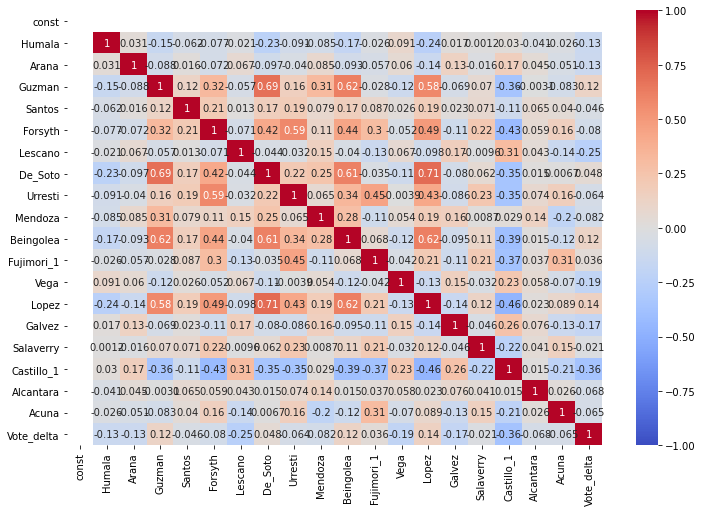

In [11]:
# Checking the correlation matrix for X
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(), vmin=-1, vmax=1, cmap="coolwarm", annot=True)
plt.show()

- The most notable free-market candidates in the first round were De_Soto and Lopez. Their correlation is pretty high (0.71). 

- De Soto also has a high correlation with Guzman (centrist) at 0.69 and Beingolea (conservative) at 0.61

- Lopez has a high correlation with Beingolea (0.62) and Guzman (0.58).  

Some multicollinearity is present. However, for the purpose of having the greatest explanatory power, we will keep all candidates in the regression. We are not necessarily interested in the actual values of the coefficient, but since we want to be able to predict the expected value of total votecount, we will accept the tradeoff of higher R2 for lower coefficient interpretability.  

In [12]:
## This is the general model at the national level 
# 1. Instantiate model
Fuji2n = sm.OLS(yn,X)

# 2. Fit model
Fuji2n_results = Fuji2n.fit()

Fuji2n_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Fujimori_2   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 5.385e+04
Date:                Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:20:05   Log-Likelihood:            -3.4317e+05
No. Observations:               84452   AIC:                         6.864e+05
Df Residuals:                   84432   BIC:                         6.866e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8328      0.247     84.284      0.000      20.348      21.317
Humala         0.1955      0.010     19.013      0.000       0.175       0.216
Arana          0.0258      0.043      0.607      0.544      -0.058       0.109
Guzman         1.0005      0.018     55.169      0.000       0.965       1.036
Santos         0.2305      0.053      4.346      0.000       0.127       0.334
Forsyth        0.5193      0.010     51.910      0.000       0.500       0.539
Lescano        0.0358      0.004      8.139      0.000       0.027       0.044
De_Soto        0.9948      0.005    205.583      0.000       0.985       1.004
Urresti        0.1564      0.008     19.450      0.000       0.141       0.172
Mendoza       -0.2299      0.006    -35.986      0.000      -0.242      -0.217
Beingolea      1.4959      0.018     83.127      0.000       1.461       1.531
Fujimori_1     1.2693      0.004    323.371      0.000       1.262       1.277
Vega          -0.2956      0.031     -9.514      0.000      -0.357      -0.235
Lopez          0.7972      0.006    132.414      0.000       0.785       0.809
Galvez        -0.3792      0.034    -11.236      0.000      -0.445      -0.313
Salaverry      0.1692      0.018      9.504      0.000       0.134       0.204
Castillo_1    -0.2335      0.002   -101.211      0.000      -0.238      -0.229
Alcantara     -0.3729      0.042     -8.804      0.000      -0.456      -0.290
Acuna          0.4875      0.005     90.112      0.000       0.477       0.498
Vote_delta     0.4983      0.004    113.439      0.000       0.490       0.507
==============================================================================
Omnibus:                     4160.693   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15096.361
Skew:                           0.093   Prob(JB):                         0.00
Kurtosis:                       5.063   Cond. No.                         302.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All regressors are statisitically significant except for Arana and have the correct signs in terms of political views with Fujimori. Beingolea, Guzman, De Soto and Lopez have the highest coefficients. This model seems to fit with expectations and has good explanatory power.  

In [13]:
## Generating the residuals and fitted values
Fuji2n_resids = Fuji2n_results.resid
Fuji2n_fittedvals = Fuji2n_results.fittedvalues 

*What does the histogram of fitted (predicted) values look like?*

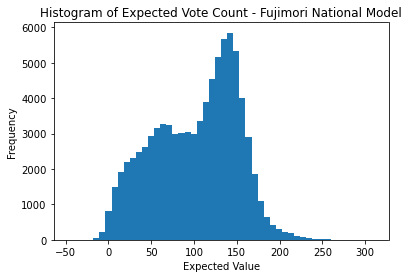

In [14]:
plt.figure()
plt.hist(Fuji2n_fittedvals, bins = 50)
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Vote Count - Fujimori National Model')
plt.show()

The data is predicting a bimodal distribution, with a thick tail on the left. 

There are a few predicted values that are below zero. That is not possible. We will replace these with zeros and recalculate the errors.These will be added to the data frame, along with the original estimates. 

In [15]:
## Creating a column with the original residual values of the national model
dfr['Fuji2n_resids']=Fuji2n_resids

In [16]:
## Creating a column with the original fitted values of the national model
dfr['Fuji2n_fittedvals']=Fuji2n_fittedvals

In [17]:
## Creating a copy of this column to modify with the new fitted values. 
dfr['NewFuji2n_fval']=Fuji2n_fittedvals

In [18]:
## Locating where the fitted values are zero
dfr.loc[dfr['NewFuji2n_fval']<0, 'NewFuji2n_fval']

364     -1.155024
365     -3.282344
376     -2.698389
577     -4.235580
686     -2.804602
           ...   
84089   -0.517708
84163   -4.095616
84169   -0.877259
84191   -2.302086
84194   -3.250558
Name: NewFuji2n_fval, Length: 588, dtype: float64

In [19]:
## Setting these 588 rows with a value of zero.
dfr.loc[dfr['NewFuji2n_fval']<0, 'NewFuji2n_fval']=0

In [20]:
## Locating where the fitted values are higher than 300, the max amount of elegible votes at a polling station
dfr.loc[dfr['NewFuji2n_fval']>300, 'NewFuji2n_fval']

20743    309.340585
Name: NewFuji2n_fval, dtype: float64

In [21]:
## Setting this row with a value of 300
dfr.loc[dfr['NewFuji2n_fval']>300, 'NewFuji2n_fval']=300

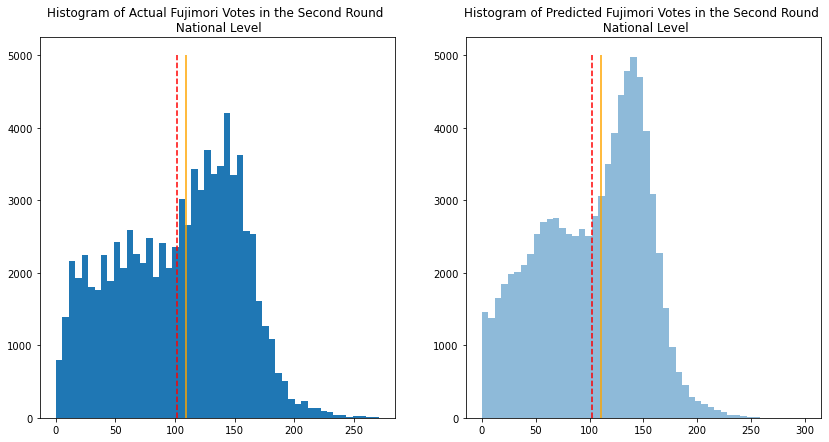

In [22]:
## Plots of predicted vs actual values after capping predicted values at zero 
plt.subplots(1,2, figsize=(14,7))

plt.subplot(1,2,1)
plt.hist(dfr['Fujimori_2'], bins = 50)
plt.vlines(dfr['Fujimori_2'].mean(), 0, 5000, color="red", linestyles="--", label='mean')
plt.vlines(dfr['Fujimori_2'].median(), 0, 5000, color="orange", linestyles="-", label='median')
plt.title('Histogram of Actual Fujimori Votes in the Second Round \n National Level')

plt.subplot(1,2,2)
plt.hist(dfr['NewFuji2n_fval'], bins = 50, alpha=0.5)
plt.vlines(dfr['NewFuji2n_fval'].mean(), 0, 5000, color="red", linestyles="--", label='mean')
plt.vlines(dfr['NewFuji2n_fval'].median(), 0, 5000, color="orange", linestyles="-", label='median')
plt.title('Histogram of Predicted Fujimori Votes in the Second Round \n National Level')
plt.show()

In [23]:
dfr['Fujimori_2'].describe()

count    84452.000000
mean       102.124082
std         50.984345
min          0.000000
25%         60.000000
50%        109.000000
75%        143.000000
max        271.000000
Name: Fujimori_2, dtype: float64

In [24]:
dfr['NewFuji2n_fval'].describe()

count    84452.000000
mean       102.155349
std         48.933606
min          0.000000
25%         62.641452
50%        110.636464
75%        141.166224
max        300.000000
Name: NewFuji2n_fval, dtype: float64

At the national level, the model predicts a binomial distribution with a mean of 102.12 and a median 110.63 and a mode ~140. The model has a longer right tail as well. These parameters are fairly similar to the actual distribution. The standard deviations are also fairly similar.  With an R2 of 0.92, this model adjusts fairly well. 

In [25]:
## Estimating the capped residuals after capping the fitted values between 0 and 300 
dfr['NewFuji2nres']=dfr['Fujimori_2']-dfr['NewFuji2n_fval']

#### 1.1.1 Checking the normality of residuals via three methods: 
- Histogram 
- Q-Q plot 
- Shapiro Test

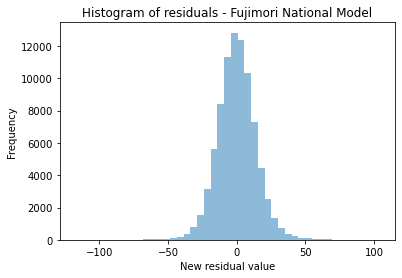

In [26]:
## Using the Histrogram to check the normality of 'capped' residuals
plt.figure()
plt.hist(dfr['NewFuji2nres'], bins = 45, alpha=0.5)
plt.xlabel('New residual value')
plt.ylabel('Frequency')
plt.title('Histogram of residuals - Fujimori National Model')
plt.show()

The ditribution of the residuals appears normal, but both tails look long. 

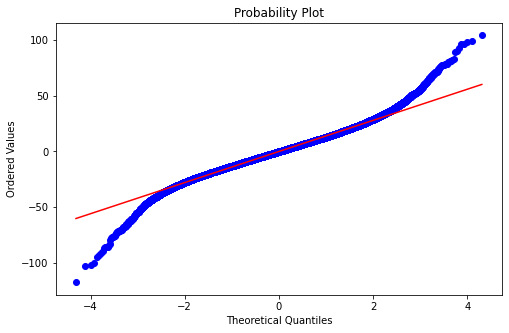

In [27]:
# Using the Q-Q plot of the ´capped' residuals
plt.figure(figsize=(8,5))
prob_plot = stats.probplot(dfr['NewFuji2nres'], dist="norm", plot=plt)
plt.title("Probability Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Values")
plt.show()

Q-Q plots the residual data against the expected quantiles from a normal distribution. In this case there is some skew at both  tails. This points to the distribution of residuals not being normal. 

In [28]:
## Trying the Shapiro Test
stats.shapiro(dfr['NewFuji2nres'])

ShapiroResult(statistic=0.9867008924484253, pvalue=0.0)

In the Shapiro test, we reject the null that hypothesis and conclude that the residuals are not normally distributed. Hence, the last two tests point to the residuals not being normal. 

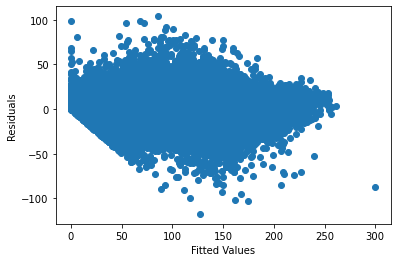

In [29]:
## Homoschedasticity test
plt.figure()
plt.scatter(dfr['NewFuji2n_fval'], dfr['NewFuji2nres'])
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

*The scatterplot is bound diagonally at the bottom because fitted values cannot be smaller in absolute terms than negative residuals (this would imply that the actual value is also negative, which is not possible). Having said this, it seems that the residuals  get smaller as fitted values are larger. That is, the model does a better job at predicting higher values.* 

*The analysis points to residuals not being normal because of outliers on both tails. This is a caveat going forward. Outliers are to be expected. This research aims to put those outliers in context, being cautious about the conclusions that can be drawn from this.* 

#### 1.1.2 Outlier analysis

To determine if a particular polling place is out of the ordinary, we will intersect two criteria: 

- The residuals are extreme values, i.e. the difference between actual and predicted value of votes for a particular polling place is at the 2.5 percentile of the residual distritbution. 

- The number of votes obtained by Fujimori in a particular polling place is in the tail (2.5 percentile) of her votes distribution. 

Polling stations that meet both criteria are flagged as outliers. 

##### 1.1.2.1 Extreme residuals

In [30]:
## Calculating the lower bounds 
loqn=dfr['NewFuji2nres'].quantile(0.025)
loqn

-26.998233424461016

In [31]:
## Creating a new outlier calculation dataframe
outlier=dfr[['Geocode', 'State', 'Province', 'District', 'Region','Poll_station', 'Fujimori_2', 'Castillo_2','NewFuji2n_fval', 'NewFuji2nres']]

In [32]:
## Creating a column for those outliers at the left end of the distibution
outlier['nleft']=0

In [33]:
outlier.loc[outlier['NewFuji2nres']<loqn, 'nleft']=1

In [34]:
outlier.nleft.value_counts()

0    82340
1     2112
Name: nleft, dtype: int64

By using percentiles we are imposing a hard limit on the number of observations in the lower bound. By definition, 2.5% the total observations is 2112. We are not using the 2stdv rule for a normal distribution because of the Shapiro and Q-Q plot results. 

##### 1.1.2.2 Extreme vote count

In [35]:
## Calculalting the percentiles for the Fujimori_2 vote distribution
quant=[0.003, 0.025, 0.05, 0.165, 0.5, 0.665, 0.95, 0.975, 0.997]

for i in quant:
    votes=dfr['Fujimori_2'].quantile(i)
    _th=100*i
    print(f'The {_th} th quantile is {votes} votes')

The 0.3 th quantile is 2.0 votes
The 2.5 th quantile is 10.0 votes
The 5.0 th quantile is 16.0 votes
The 16.5 th quantile is 42.0 votes
The 50.0 th quantile is 109.0 votes
The 66.5 th quantile is 132.0 votes
The 95.0 th quantile is 175.0 votes
The 97.5 th quantile is 187.0 votes
The 99.7 th quantile is 227.0 votes


*the 2.5th percentile of the Fujimori national distribution is 10 votes.*

##### 1.1.1.3 Intersecting extreme negative residuals and low vote count

This subset would be the negative outliers. 

In [36]:
## Create a column for negative outliers 
outlier['neg_out']=0
outlier.loc[(outlier['nleft']==1) & (outlier['Fujimori_2']<11), 'neg_out']=1

In [37]:
#Let's create a dataframe for Fujimori's negative outliers
exnegf=outlier[outlier['neg_out']==1]

In [38]:
exnegf

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,NewFuji2n_fval,NewFuji2nres,nleft,neg_out
62,10601,AMAZONAS,CONDORCANQUI,NIEVA,East,900100,0.0,126.0,42.669331,-42.669331,1,1
63,10601,AMAZONAS,CONDORCANQUI,NIEVA,East,900103,0.0,106.0,28.790936,-28.790936,1,1
64,10602,AMAZONAS,CONDORCANQUI,RIO SANTIAGO,East,900108,2.0,92.0,32.141478,-30.141478,1,1
66,10603,AMAZONAS,CONDORCANQUI,EL CENEPA,East,900115,1.0,163.0,48.435695,-47.435695,1,1
67,10603,AMAZONAS,CONDORCANQUI,EL CENEPA,East,900117,3.0,163.0,42.704922,-39.704922,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
80578,80118,HUANCAVELICA,HUANCAVELICA,YAULI,Central,901317,0.0,203.0,29.575032,-29.575032,1,1
80579,80118,HUANCAVELICA,HUANCAVELICA,YAULI,Central,901318,8.0,199.0,41.687421,-33.687421,1,1
83492,150704,LORETO,DATEM DEL MARA��ON,MANSERICHE,East,902519,3.0,147.0,36.529733,-33.529733,1,1
83496,150705,LORETO,DATEM DEL MARA��ON,MORONA,East,902526,1.0,67.0,30.935305,-29.935305,1,1


**184 polls flagged of a possible 2112 (8.71%).**

In [39]:
## How many votes for Castillo are in these flagged poll places
exnegf['Castillo_2'].sum()

24720.0

In [40]:
## How many votes for Fujimori are in these flagged poll places
exnegf['Fujimori_2'].sum()

894.0

All these outliers account for 24720 votes for Castillo and 894 for Fujimori. If, in the extreme, these results were discarded, the net gain for Fujimori woudl be 23826 votes. This is not enough to challenge the current diffence of 44k. 

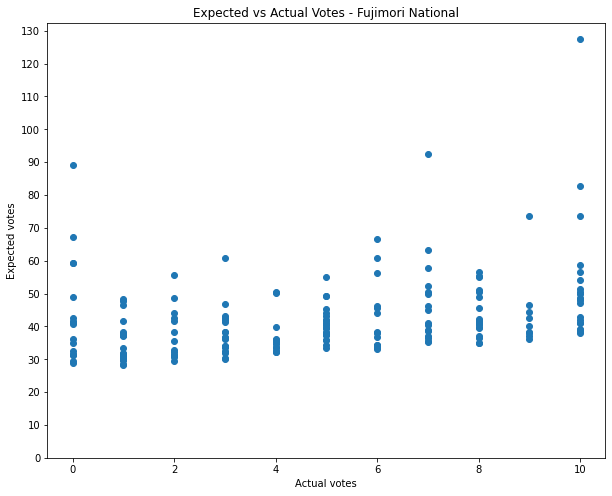

In [41]:
## Scatter plot of expected vs actual votes for 184 "flagged" polling places 
plt.figure(figsize=(10,8))
plt.scatter(exnegf['Fujimori_2'], exnegf['NewFuji2n_fval'])
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
plt.yticks(np.arange(0, 140, step=10))
plt.title('Expected vs Actual Votes - Fujimori National')
plt.show()

We see that there are some extreme outliers starting around 50 expected votes for all actual vote counts. Nevertheless, these seem to be concentrated in the lower expected vote predictions. 

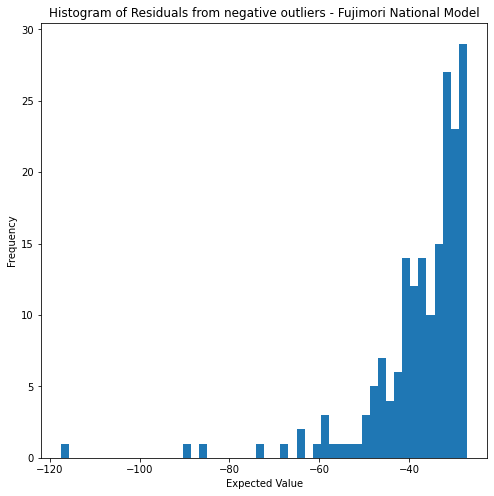

In [42]:
plt.figure(figsize=(8,8))
plt.hist(exnegf['NewFuji2nres'], bins = 50)
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals from negative outliers - Fujimori National Model')
plt.show()

In [43]:
exnegf['NewFuji2nres'].describe()

count    184.000000
mean     -37.555766
std       11.741494
min     -117.434749
25%      -40.845160
50%      -33.919508
75%      -30.136129
max      -27.079667
Name: NewFuji2nres, dtype: float64

When analyzing the histogram of residuals, we indeed see that the values concentrated (75% of the distribution) from -40.85 to -27.08. That is, the outliers tend to be concentrated where the residuals are smaller. It is possible that in these 138 polling stations of 84k, Fujimori got a lower than expected vote count because of momentum from the other candidate. For the other 46 polling stations, as the residual is larger, it gets harder to explain, but it is a small subset of the total population.   

In [44]:
##Where are these polling stations?  
exnegf['State'].value_counts()

AMAZONAS        47
LORETO          44
CAJAMARCA       40
CUSCO            9
AYACUCHO         8
ANCASH           6
PIURA            6
HUANCAVELICA     6
PUNO             4
HUANUCO          3
JUNIN            2
AREQUIPA         2
TACNA            2
LIMA             2
UCAYALI          2
LA LIBERTAD      1
Name: State, dtype: int64

These observations seem to be mostly concentrated in Amazonas, Loreto and Cajamarca. 

Now, let's clean the exnegf dataframe to export to CSV to use with Tableau. 

In [45]:
## rename the fitted and residual columns for Coast 
exnegf.rename(columns={'NewFuji2n_fval':'fitted', 'NewFuji2nres':'residuals'}, inplace=True)

In [46]:
## drop the nleft and neg_out columns. they are not necessary anymore
exnegf.drop(columns=['nleft', 'neg_out'], inplace=True)

In [47]:
## We'll export this clean dataset for use in Tableau
exnegf.to_csv('data/fuji_totnegoutnat.csv', index=False)

### 1. 2 Regional Models 

To perform an acid test on the previous methodology, we propose performing individual regressions on the five regions and adding up the outliers. This allows for greater variation and nuance at the regional level. That is, the lower bound of each region is different. This methodology should include more outliers than the previous one. We will contrast the results with the previous methodology.  

#### 1.2.1. Coast Model

In [48]:
## The target variable is the vote count per polling place for Fujimori in the second round 
yfc=dfr[dfr['Region']=='Coast'].iloc[:,9]

In [49]:
## The independent variables are the total votes for the second round and the votes of individual candidates in the first round 
Xc=dfr[dfr['Region']=='Coast'].iloc[:,[17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39]]

In [50]:
## This is the general model at the national level 
Xc=sm.add_constant(Xc)

# 1. Instantiate model
Fuji2c = sm.OLS(yfc,Xc)

# 2. Fit model
Fuji2c_results = Fuji2c.fit()

Fuji2c_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Fujimori_2   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                 1.187e+04
Date:                Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:20:07   Log-Likelihood:            -1.8398e+05
No. Observations:               45554   AIC:                         3.680e+05
Df Residuals:                   45534   BIC:                         3.682e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.2487      0.484     60.467      0.000      28.301      30.197
Humala         0.1552      0.028      5.524      0.000       0.100       0.210
Arana          0.2212      0.072      3.059      0.002       0.079       0.363
Guzman         0.7160      0.021     33.775      0.000       0.674       0.758
Santos         0.4878      0.066      7.412      0.000       0.359       0.617
Forsyth        0.5718      0.013     42.978      0.000       0.546       0.598
Lescano        0.0642      0.012      5.234      0.000       0.040       0.088
De_Soto        1.1609      0.007    163.446      0.000       1.147       1.175
Urresti        0.1681      0.010     17.213      0.000       0.149       0.187
Mendoza       -0.1770      0.013    -14.128      0.000      -0.202      -0.152
Beingolea      1.1140      0.020     55.056      0.000       1.074       1.154
Fujimori_1     1.1009      0.005    215.286      0.000       1.091       1.111
Vega          -0.2535      0.049     -5.154      0.000      -0.350      -0.157
Lopez          0.6660      0.007     92.606      0.000       0.652       0.680
Galvez         0.0346      0.064      0.544      0.586      -0.090       0.159
Salaverry      0.3318      0.027     12.185      0.000       0.278       0.385
Castillo_1    -0.4157      0.007    -62.608      0.000      -0.429      -0.403
Alcantara     -0.2104      0.059     -3.537      0.000      -0.327      -0.094
Acuna          0.5005      0.007     74.466      0.000       0.487       0.514
Vote_delta     0.5166      0.007     77.480      0.000       0.504       0.530
==============================================================================
Omnibus:                     2916.085   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13815.963
Skew:                          -0.057   Prob(JB):                         0.00
Kurtosis:                       5.696   Cond. No.                         468.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
## Storing fitted values and residuals. 
Fuji2c_resids = Fuji2c_results.resid
Fuji2c_fittedvals = Fuji2c_results.fittedvalues

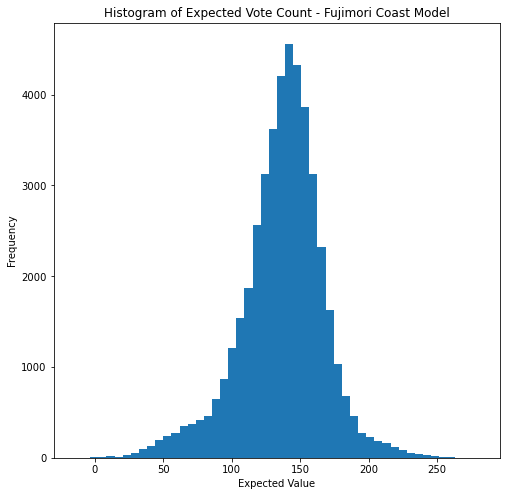

In [52]:
plt.figure(figsize=(8,8))
plt.hist(Fuji2c_fittedvals, bins = 50)
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Vote Count - Fujimori Coast Model')
plt.show()

There are a few predicted values that are below zero. We replace them with zeros and calculate the residuals like in the previous case. 

In [53]:
## Creating a column with the original residual values of the Coast model
dfr['Fuji2c_resids']=Fuji2c_resids

In [54]:
## Creating a column with the original fitted values of the national model
dfr['Fuji2c_fittedvals']=Fuji2c_fittedvals

In [55]:
## Creating a copy of this column to modify with the new fitted values. 
dfr['NewFuji2c_fval']=Fuji2c_fittedvals

In [56]:
dfr.loc[dfr['NewFuji2c_fval']<0, 'NewFuji2c_fval']

31174    -0.742604
62905    -5.616216
76866   -15.134352
78435    -0.685467
81600    -3.548312
Name: NewFuji2c_fval, dtype: float64

In [57]:
## Setting these rows with a value of zero
dfr.loc[dfr['NewFuji2c_fval']<0, 'NewFuji2c_fval']=0

In [58]:
## Checking if there are any values outside of the right bounds of 300 votes per polling station
dfr.loc[dfr['NewFuji2c_fval']>300, 'NewFuji2c_fval']

Series([], Name: NewFuji2c_fval, dtype: float64)

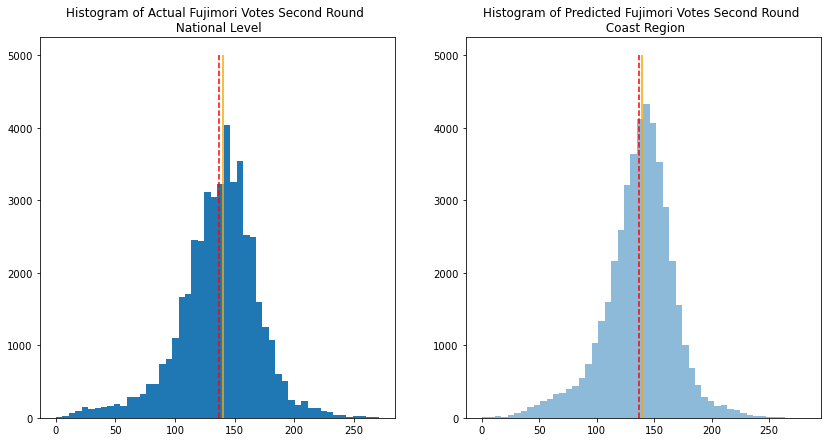

In [59]:
## Plots of predicted vs actual values 
plt.subplots(1,2, figsize=(14,7))

plt.subplot(1,2,1)
plt.hist(dfr[dfr['Region']=='Coast']['Fujimori_2'], bins = 50)
plt.vlines(dfr[dfr['Region']=='Coast']['Fujimori_2'].mean(), 0, 5000, color="red", linestyles="--", label='mean')
plt.vlines(dfr[dfr['Region']=='Coast']['Fujimori_2'].median(), 0, 5000, color="orange", linestyles="-", label='median')
plt.title('Histogram of Actual Fujimori Votes Second Round \n National Level')

plt.subplot(1,2,2)
plt.hist(dfr['NewFuji2c_fval'], bins = 50, alpha=0.5)
plt.vlines(dfr['NewFuji2c_fval'].mean(), 0, 5000, color="red", linestyles="--", label='mean')
plt.vlines(dfr['NewFuji2c_fval'].median(), 0, 5000, color="orange", linestyles="-", label='median')
plt.title('Histogram of Predicted Fujimori Votes Second Round \n Coast Region')
plt.show()

The predicted distribution seems very similar in mean and mode to the actual distribution. 

In [60]:
dfr[dfr['Region']=='Coast']['Fujimori_2'].describe()

count    45554.000000
mean       136.855973
std         33.505368
min          0.000000
25%        119.000000
50%        140.000000
75%        157.000000
max        271.000000
Name: Fujimori_2, dtype: float64

In [61]:
dfr['NewFuji2c_fval'].describe()

count    45554.000000
mean       136.856538
std         30.559207
min          0.000000
25%        121.175216
50%        139.542565
75%        155.176295
max        281.116458
Name: NewFuji2c_fval, dtype: float64

The predicted and actual distributions are fairly close. The acutual distribution has a larger standard deviation. Also, the predicted distribution has a longer tails on the right and a thicker tail on the left.   

In [62]:
## Estimating the capped residuals 
dfr['NewFuji2cres']=dfr[dfr['Region']=='Coast']['Fujimori_2']-dfr[dfr['Region']=='Coast']['NewFuji2c_fval']

##### 1.2.1.1 Checking the normality of residuals via three methods: 
- Histogram 
- Q-Q plot 
- Shapiro Test

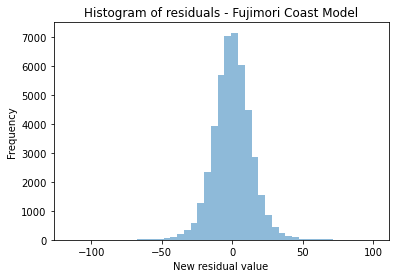

In [63]:
## Using the Histrogram to check the normality of 'capped' residuals
plt.figure()
plt.hist(dfr[dfr['Region']=='Coast']['NewFuji2cres'], bins = 45, alpha=0.5)
plt.xlabel('New residual value')
plt.ylabel('Frequency')
plt.title('Histogram of residuals - Fujimori Coast Model')
plt.show()

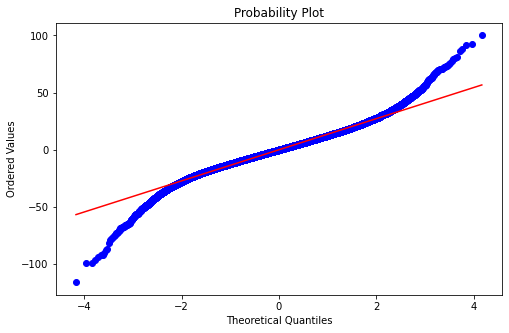

In [64]:
# Using the Q-Q plot of the ´capped' residuals
plt.figure(figsize=(8,5))
prob_plot = stats.probplot(dfr[dfr['Region']=='Coast']['NewFuji2cres'], dist="norm", plot=plt)
plt.title("Probability Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Values")
plt.show()

In [65]:
## Trying the Shapiro Test
stats.shapiro(dfr[dfr['Region']=='Coast']['NewFuji2cres'])

ShapiroResult(statistic=0.9789120554924011, pvalue=0.0)

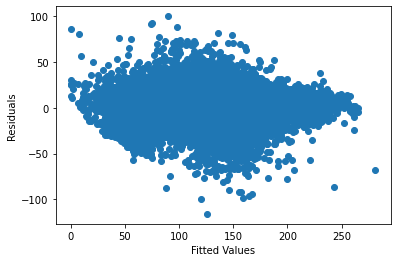

In [66]:
## Homoschedasticity test
plt.figure()
plt.scatter(dfr[dfr['Region']=='Coast']['NewFuji2c_fval'], dfr[dfr['Region']=='Coast']['NewFuji2cres'])
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

The residuals show the same behavior as in the case of the national model, non-normality at the tails of the distribution. Residuals are not homoschedastic. The same caveat applies. The model is not doing a good job at predicting outliers. 

##### 1.2.1.2 Outlier Analysis

We will follow the same methodology as in the case of the national model. We will create a separate dataframe for the coast region. Sequential regional models will be added to this dataframe. We will assess the results of the consolidated regional dataframe at the end of this section. 

**Extreme residuals**

In [67]:
## Calculate the lower bound for the residuals in the Coast model
loqc=dfr[dfr['Region']=='Coast']['NewFuji2cres'].quantile(0.025)

In [68]:
loqc

-26.855214322412035

The lower bound of the residual distribution for the Coast model is nearly identical to the National model. As we saw earlier, the Coast region accounts for more than half of all polling stations. 

In [69]:
## Creating a new outlier calculation dataframe
precoast=dfr[['Geocode', 'State', 'Province', 'District', 'Region','Poll_station', 'Fujimori_2', 'Castillo_2','NewFuji2c_fval', 'NewFuji2cres']]

In [70]:
outcoast=precoast.loc[precoast['Region']=='Coast', :]

In [71]:
outcoast

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,NewFuji2c_fval,NewFuji2cres
970,240101,CALLAO,CALLAO,CALLAO,Coast,76030,160.0,61.0,155.347040,4.652960
971,240101,CALLAO,CALLAO,CALLAO,Coast,76032,133.0,73.0,136.310961,-3.310961
972,240101,CALLAO,CALLAO,CALLAO,Coast,76036,137.0,64.0,141.758663,-4.758663
977,240101,CALLAO,CALLAO,CALLAO,Coast,76050,158.0,67.0,135.361733,22.638267
983,240101,CALLAO,CALLAO,CALLAO,Coast,76076,184.0,40.0,160.149781,23.850219
...,...,...,...,...,...,...,...,...,...,...
84343,230304,TUMBES,ZARUMILLA,AGUAS VERDES,Coast,75893,137.0,36.0,123.736493,13.263507
84344,230101,TUMBES,TUMBES,TUMBES,Coast,75506,163.0,78.0,154.790924,8.209076
84345,230101,TUMBES,TUMBES,TUMBES,Coast,75517,135.0,107.0,133.521210,1.478790
84346,230106,TUMBES,TUMBES,SAN JUAN DE LA VIRGEN,Coast,75718,155.0,110.0,140.535026,14.464974


In [72]:
## Creating the the lower bound dummy
outcoast['nleft']=0

In [73]:
## Assigning a value of 1 if it's lower than the 2.5% percentile
outcoast.loc[outcoast['NewFuji2cres']<loqc, 'nleft']=1

In [74]:
outcoast.nleft.value_counts()

0    44415
1     1139
Name: nleft, dtype: int64

There are 1139 potential outliers from the Coast region. 

In [75]:
outcoast.head(3)

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,NewFuji2c_fval,NewFuji2cres,nleft
970,240101,CALLAO,CALLAO,CALLAO,Coast,76030,160.0,61.0,155.347040,4.652960,0
971,240101,CALLAO,CALLAO,CALLAO,Coast,76032,133.0,73.0,136.310961,-3.310961,0
972,240101,CALLAO,CALLAO,CALLAO,Coast,76036,137.0,64.0,141.758663,-4.758663,0


**Extreme vote count**

In [76]:
## Calculalting the percentiles for the Fujimori_2 vote distribution
quant=[0.003, 0.025, 0.05, 0.165, 0.5, 0.665, 0.95, 0.975, 0.997]

for i in quant:
    votes=dfr[dfr['Region']=='Coast']['Fujimori_2'].quantile(i)
    _th=100*i
    print(f'The {_th} th quantile is {votes} votes')

The 0.3 th quantile is 19.0 votes
The 2.5 th quantile is 56.0 votes
The 5.0 th quantile is 77.0 votes
The 16.5 th quantile is 109.0 votes
The 50.0 th quantile is 140.0 votes
The 66.5 th quantile is 151.0 votes
The 95.0 th quantile is 185.0 votes
The 97.5 th quantile is 198.0 votes
The 99.7 th quantile is 236.0 votes


In this case, using the 2.5% threshold, the lower bound would be 19 votes. 

**Intersecting extreme negative residuals and low vote count**

In [77]:
## Create a column for negative outliers 
outcoast['neg_out']=0
outcoast.loc[(outcoast['nleft']==1) & (outcoast['Fujimori_2']<20), 'neg_out']=1

In [78]:
#Let's create a dataframe for Fujimori's extreme negative outliers in the coast
exnegfc=outcoast[outcoast['neg_out']==1]

In [79]:
exnegfc

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,NewFuji2c_fval,NewFuji2cres,nleft,neg_out
4514,190201,PIURA,AYABACA,AYABACA,Coast,66622,15.0,92.0,52.957746,-37.957746,1,1
4659,190205,PIURA,AYABACA,PACAIPAMPA,Coast,66803,19.0,94.0,51.882637,-32.882637,1,1
4668,190206,PIURA,AYABACA,SAPILLICA,Coast,66843,17.0,148.0,63.184769,-46.184769,1,1
7804,140101,LIMA,LIMA,LIMA,Coast,33563,0.0,48.0,87.580018,-87.580018,1,1
9460,140513,LIMA,HUAURA,SAYAN,Coast,59537,16.0,34.0,44.250776,-28.250776,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
83705,190201,PIURA,AYABACA,AYABACA,Coast,66626,18.0,71.0,45.860795,-27.860795,1,1
83716,190201,PIURA,AYABACA,AYABACA,Coast,66642,14.0,83.0,55.361045,-41.361045,1,1
83874,190205,PIURA,AYABACA,PACAIPAMPA,Coast,66794,11.0,69.0,38.816074,-27.816074,1,1
83884,190205,PIURA,AYABACA,PACAIPAMPA,Coast,66828,15.0,118.0,53.938545,-38.938545,1,1


We have identified 71 outliers of a possible 1139 (6.23%).

9 duplicates were dropped. 

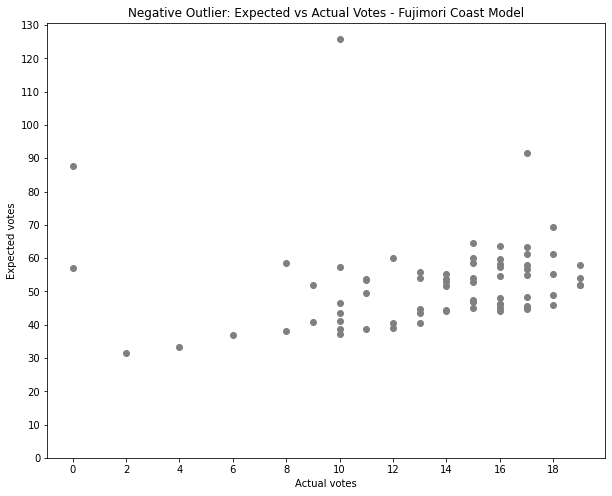

In [80]:
## Scatter plot of expected vs actual votes for 71"flagged" polling places 
plt.figure(figsize=(10,8))
plt.scatter(exnegfc['Fujimori_2'], exnegfc['NewFuji2c_fval'], color='gray')
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
plt.xticks(np.arange(0, 20, step=2))
plt.yticks(np.arange(0, 140, step=10))
plt.title('Negative Outlier: Expected vs Actual Votes - Fujimori Coast Model')
plt.show()

In this case, there are very few outliers below 10 actual votes. There are a few outliers also where expected votes should have been higher than 50, yet for the most part they are concentrated around 40 votes. 

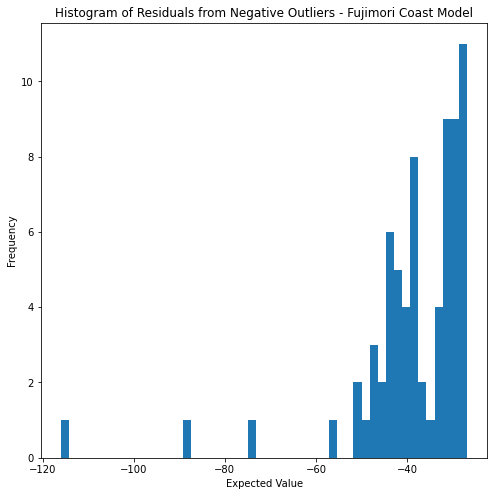

In [81]:
plt.figure(figsize=(8,8))
plt.hist(exnegfc['NewFuji2cres'], bins = 50)
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals from Negative Outliers - Fujimori Coast Model')
plt.show()

In [82]:
exnegfc['NewFuji2cres'].describe()

count     71.000000
mean     -38.843933
std       13.906031
min     -115.929494
25%      -42.751772
50%      -37.211090
75%      -30.161639
max      -26.865063
Name: NewFuji2cres, dtype: float64

The residuals tell us that the mode is in the smallest bin of the histogram, close to the minimum value. Furthermore, 75% of the distribution is between -26 and -30. If a candidate got 18 votes when they expected 45, is that particularly odd? 

#### 1.2.2 South Model

In [83]:
## The target variable is the vote count per polling place for Fujimori in the second round 
yfs=dfr[dfr['Region']=='South'].iloc[:,9]

In [84]:
## The independent variables are the total votes for the second round and the votes of individual candidates in the first round 
Xs=dfr[dfr['Region']=='South'].iloc[:,[17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39]]

In [85]:
## This is the general model for the South model 
Xs=sm.add_constant(Xs)

# 1. Instantiate model
Fuji2s = sm.OLS(yfs,Xs)

# 2. Fit model
Fuji2s_results = Fuji2s.fit()

Fuji2s_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Fujimori_2   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     9075.
Date:                Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:20:10   Log-Likelihood:                -54226.
No. Observations:               14831   AIC:                         1.085e+05
Df Residuals:                   14811   BIC:                         1.086e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7845      0.422     23.208      0.000       8.958      10.611
Humala         0.1625      0.021      7.899      0.000       0.122       0.203
Arana         -0.2529      0.049     -5.146      0.000      -0.349      -0.157
Guzman         0.5112      0.041     12.524      0.000       0.431       0.591
Santos        -0.1161      0.084     -1.385      0.166      -0.280       0.048
Forsyth        0.5252      0.026     19.864      0.000       0.473       0.577
Lescano        0.1284      0.004     32.509      0.000       0.121       0.136
De_Soto        0.9602      0.007    132.881      0.000       0.946       0.974
Urresti        0.0750      0.025      3.003      0.003       0.026       0.124
Mendoza       -0.0305      0.007     -4.533      0.000      -0.044      -0.017
Beingolea      0.5256      0.052     10.107      0.000       0.424       0.627
Fujimori_1     1.5386      0.013    116.871      0.000       1.513       1.564
Vega          -0.2908      0.048     -6.120      0.000      -0.384      -0.198
Lopez          0.7459      0.017     44.654      0.000       0.713       0.779
Galvez        -0.3200      0.048     -6.730      0.000      -0.413      -0.227
Salaverry      0.0981      0.025      3.894      0.000       0.049       0.148
Castillo_1    -0.1081      0.003    -35.577      0.000      -0.114      -0.102
Alcantara     -0.2888      0.055     -5.250      0.000      -0.397      -0.181
Acuna         -0.4132      0.026    -15.669      0.000      -0.465      -0.362
Vote_delta     0.2845      0.009     31.170      0.000       0.267       0.302
==============================================================================
Omnibus:                      578.382   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1760.413
Skew:                           0.079   Prob(JB):                         0.00
Kurtosis:                       4.681   Cond. No.                         484.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model has a good fit with 0.92 R2. Only one of the coefficients is not statistically significant. The signs of the coefficients are as expected, except for Acuna, a provincial businessman that supported Fujimori in the second round. In the south, his voters could have migrated to Castillo. 

In [86]:
## Storing fitted values and residuals. 
Fuji2s_resids = Fuji2s_results.resid
Fuji2s_fittedvals = Fuji2s_results.fittedvalues

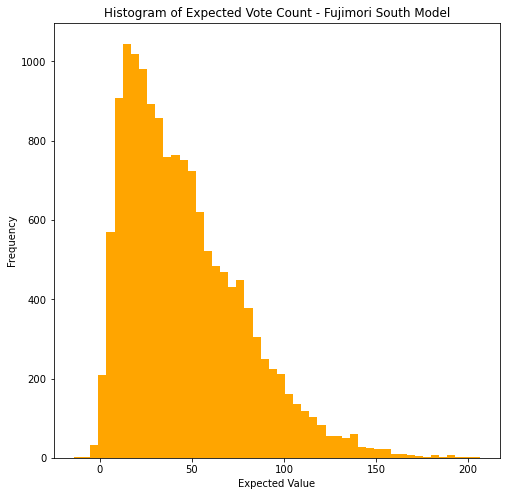

In [87]:
plt.figure(figsize=(8,8))
plt.hist(Fuji2s_fittedvals, bins = 50, color='orange')
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Vote Count - Fujimori South Model')
plt.show()

The left tail of negative fitted values needs to be capped at zero. 

In [88]:
## Creating a column with the original residual values of the South model
dfr['Fuji2s_resids']=Fuji2s_resids

In [89]:
## Creating a column with the original fitted values of the South model
dfr['Fuji2s_fittedvals']=Fuji2s_fittedvals

In [90]:
## Creating a copy of this column to modify with the new fitted values. 
dfr['NewFuji2s_fval']=Fuji2s_fittedvals

In [91]:
## Setting these rows with a value of zero
dfr.loc[dfr['NewFuji2s_fval']<0, 'NewFuji2s_fval']=0

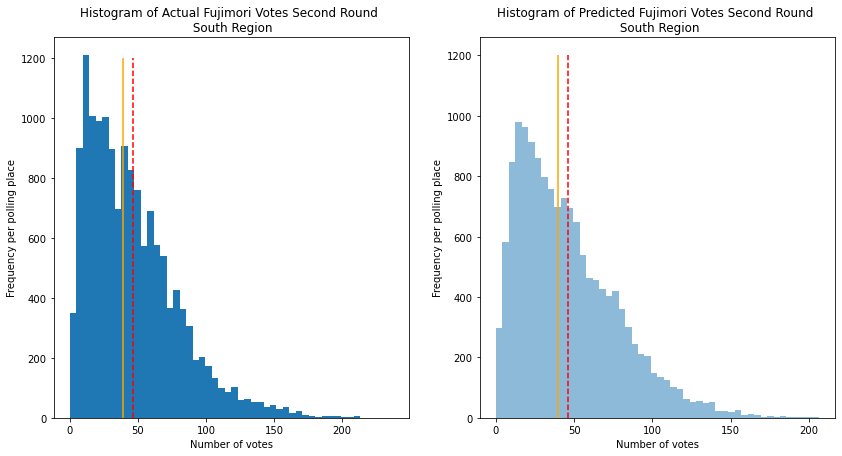

In [92]:
## Plots of predicted vs actual values 
plt.subplots(1,2, figsize=(14,7))

plt.subplot(1,2,1)
plt.hist(dfr[dfr['Region']=='South']['Fujimori_2'], bins = 50)
plt.vlines(dfr[dfr['Region']=='South']['Fujimori_2'].mean(), 0, 1200, color="red", linestyles="--", label='mean')
plt.vlines(dfr[dfr['Region']=='South']['Fujimori_2'].median(), 0, 1200, color="orange", linestyles="-", label='median')
plt.xlabel('Number of votes')
plt.ylabel('Frequency per polling place')
plt.title('Histogram of Actual Fujimori Votes Second Round \n South Region')

plt.subplot(1,2,2)
plt.hist(dfr['NewFuji2s_fval'], bins = 50, alpha=0.5)
plt.xlabel('Number of votes')
plt.ylabel('Frequency per polling place')
plt.vlines(dfr['NewFuji2s_fval'].mean(), 0, 1200, color="red", linestyles="--", label='mean')
plt.vlines(dfr['NewFuji2s_fval'].median(), 0, 1200, color="orange", linestyles="-", label='median')
plt.title('Histogram of Predicted Fujimori Votes Second Round \n South Region')
plt.show()

In [93]:
dfr[dfr['Region']=='South']['Fujimori_2'].describe()

count    14831.000000
mean        46.092037
std         33.310442
min          0.000000
25%         20.000000
50%         39.000000
75%         64.000000
max        237.000000
Name: Fujimori_2, dtype: float64

In [94]:
dfr['NewFuji2s_fval'].describe()

count    14831.000000
mean        46.099106
std         31.955107
min          0.000000
25%         20.833187
50%         39.533858
75%         65.136465
max        206.337442
Name: NewFuji2s_fval, dtype: float64

The distributions are similar in median and mean, but the mode is bigger for the actual distribution and is at the lower end of the distribution. The actual distribtion seems to have a much longer tail on the right. 

In [95]:
## Estimating the capped residuals 
dfr['NewFuji2sres']=dfr[dfr['Region']=='South']['Fujimori_2']-dfr[dfr['Region']=='South']['NewFuji2s_fval']

##### 1.2.2.1 Checking the normality of residuals

Using 3 methods: 
- Histogram 
- Q-Q plot 
- Shapiro Test

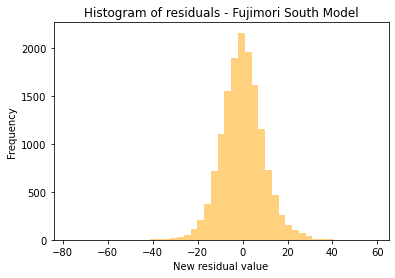

In [96]:
## Using the Histrogram to check the normality of 'capped' residuals
plt.figure()
plt.hist(dfr[dfr['Region']=='South']['NewFuji2sres'], bins = 45, color='orange', alpha=0.5)
plt.xlabel('New residual value')
plt.ylabel('Frequency')
plt.title('Histogram of residuals - Fujimori South Model')
plt.show()

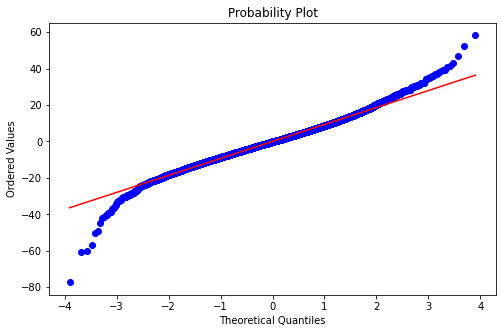

In [97]:
# Using the Q-Q plot of the ´capped' residuals
plt.figure(figsize=(8,5))
prob_plot = stats.probplot(dfr[dfr['Region']=='South']['NewFuji2sres'], dist="norm", plot=plt)
plt.title("Probability Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Values")
plt.show()

The residuals show the same characteristics as the previous case. 

In [98]:
## Trying the Shapiro Test
stats.shapiro(dfr[dfr['Region']=='South']['NewFuji2sres'])

ShapiroResult(statistic=0.9886186122894287, pvalue=1.412045397320392e-32)

The shapiro test rejects the null of normality of the distribution. 

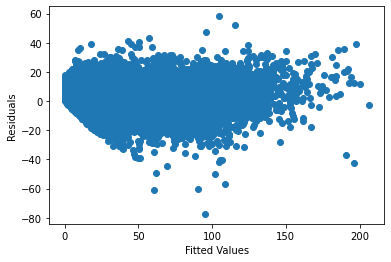

In [99]:
## Homoschedasticity test
plt.figure()
plt.scatter(dfr[dfr['Region']=='South']['NewFuji2s_fval'], dfr[dfr['Region']=='South']['NewFuji2sres'])
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

In this case, the plot sees to be more homoschedastic than in the previous models. 

##### 1.2.2.2 Outlier Analysis

**Extreme residuals**

In [100]:
## Calculate the lower bound for the residuals in the South model
loqs=dfr[dfr['Region']=='South']['NewFuji2sres'].quantile(0.025)

In [101]:
loqs

-17.80151061979696

In [102]:
## Creating a new outlier calculation dataframe
presouth=dfr[['Geocode', 'State', 'Province', 'District', 'Region','Poll_station', 'Fujimori_2', 'Castillo_2','NewFuji2s_fval', 'NewFuji2sres']]

In [103]:
## Keeping only observations from the south
outsouth=presouth.loc[presouth['Region']=='South', :]

In [104]:
outsouth.head(3)

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,NewFuji2s_fval,NewFuji2sres
363,40101,AREQUIPA,AREQUIPA,AREQUIPA,South,4961,152.0,91.0,142.242486,9.757514
364,30502,APURIMAC,COTABAMBAS,COYLLURQUI,South,900502,16.0,149.0,3.294083,12.705917
365,30504,APURIMAC,COTABAMBAS,HAQUIRA,South,900507,2.0,154.0,1.293906,0.706094


In [105]:
## Creating a dummy for the lower bound
outsouth['nleft']=0

In [106]:
## Flaggin those with a residual lower than the left bound
outsouth.loc[outsouth['NewFuji2sres']<loqs, 'nleft']=1

In [107]:
outsouth.nleft.value_counts()

0    14460
1      371
Name: nleft, dtype: int64

There are 371 possible outliers. 

In [108]:
outsouth.head(3)

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,NewFuji2s_fval,NewFuji2sres,nleft
363,40101,AREQUIPA,AREQUIPA,AREQUIPA,South,4961,152.0,91.0,142.242486,9.757514,0
364,30502,APURIMAC,COTABAMBAS,COYLLURQUI,South,900502,16.0,149.0,3.294083,12.705917,0
365,30504,APURIMAC,COTABAMBAS,HAQUIRA,South,900507,2.0,154.0,1.293906,0.706094,0


**Extreme vote count**

In [109]:
## Calculalting the percentiles for the Fujimori_2 vote distribution
quant=[0.003, 0.025, 0.05, 0.165, 0.5, 0.665, 0.95, 0.975, 0.997]

for i in quant:
    votes=dfr[dfr['Region']=='South']['Fujimori_2'].quantile(i)
    _th=100*i
    print(f'The {_th} th quantile is {votes} votes')

The 0.3 th quantile is 1.0 votes
The 2.5 th quantile is 5.0 votes
The 5.0 th quantile is 7.0 votes
The 16.5 th quantile is 14.0 votes
The 50.0 th quantile is 39.0 votes
The 66.5 th quantile is 55.0 votes
The 95.0 th quantile is 110.0 votes
The 97.5 th quantile is 129.0 votes
The 99.7 th quantile is 174.0 votes


In this case, the lower 2.5% bound is 5 votes. 

**Polling places with extreme negative residuals and low vote count**

In [110]:
## Create a column for negative outliers 
outsouth['neg_out']=0
outsouth.loc[(outsouth['nleft']==1) & (outsouth['Fujimori_2']<5), 'neg_out']=1

In [111]:
#Let's create a dataframe for Fujimori's extreme negative outliers in the south
exnegfs=outsouth[outsouth['neg_out']==1]

In [112]:
exnegfs.head(3)

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,NewFuji2s_fval,NewFuji2sres,nleft,neg_out
4947,200106,PUNO,PUNO,CHUCUITO,South,902814,4.0,215.0,24.638190,-20.638190,1,1
5957,50307,AYACUCHO,HUANTA,SANTILLANA,South,9643,3.0,136.0,23.717993,-20.717993,1,1
11284,50107,AYACUCHO,HUAMANGA,SAN JUAN BAUTISTA,South,9144,2.0,241.0,21.252511,-19.252511,1,1


In [113]:
exnegfs.shape

(24, 12)

There are only 24 possible outliers. 

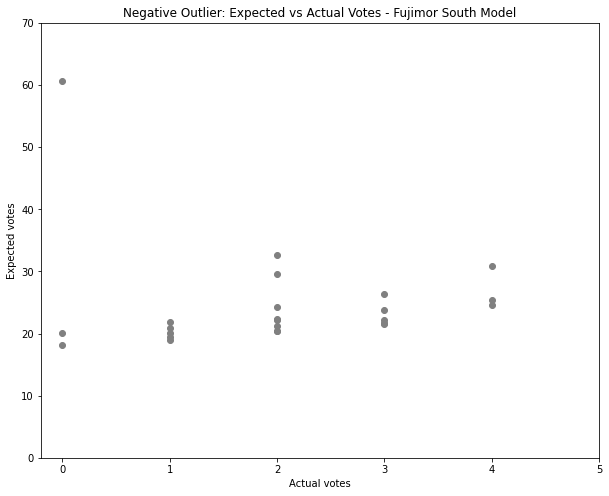

In [114]:
## Scatter plot of expected vs actual votes for "flagged" polling places 
plt.figure(figsize=(10,8))
plt.scatter(exnegfs['Fujimori_2'], exnegfs['NewFuji2s_fval'], color='gray')
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
plt.xticks(np.arange(0, 6, step=1))
plt.yticks(np.arange(0, 80, step=10))
plt.title('Negative Outlier: Expected vs Actual Votes - Fujimor South Model')
plt.show()

In this case, we see very few outliers where expected valued differs by 30 votes. In most cases, it's in the 20 range.  

#### 1.2.3 Central Model

In [115]:
## The target variable is the vote count per polling place for Fujimori in the second round 
yft=dfr[dfr['Region']=='Central'].iloc[:,9]

In [116]:
## The independent variables are the total votes for the second round and the votes of individual candidates in the first round 
Xt=dfr[dfr['Region']=='Central'].iloc[:,[17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39]]

In [117]:
## This is the general model at the national level 
Xt=sm.add_constant(Xt)

# 1. Instantiate model
Fuji2t = sm.OLS(yft,Xt)

# 2. Fit model
Fuji2t_results = Fuji2t.fit()

Fuji2t_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Fujimori_2   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     5016.
Date:                Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:20:12   Log-Likelihood:                -55135.
No. Observations:               14039   AIC:                         1.103e+05
Df Residuals:                   14019   BIC:                         1.105e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3211      0.508     28.180      0.000      13.325      15.317
Humala         0.0057      0.025      0.228      0.820      -0.043       0.054
Arana          0.4217      0.076      5.547      0.000       0.273       0.571
Guzman         0.5598      0.059      9.545      0.000       0.445       0.675
Santos         0.7748      0.132      5.875      0.000       0.516       1.033
Forsyth        0.4970      0.030     16.702      0.000       0.439       0.555
Lescano        0.1321      0.016      8.439      0.000       0.101       0.163
De_Soto        1.0051      0.016     61.347      0.000       0.973       1.037
Urresti       -0.0713      0.030     -2.406      0.016      -0.129      -0.013
Mendoza       -0.2399      0.018    -13.046      0.000      -0.276      -0.204
Beingolea      0.9104      0.070     12.938      0.000       0.772       1.048
Fujimori_1     1.5779      0.009    170.383      0.000       1.560       1.596
Vega           0.0741      0.060      1.229      0.219      -0.044       0.192
Lopez          0.5766      0.017     34.441      0.000       0.544       0.609
Galvez        -0.2787      0.051     -5.485      0.000      -0.378      -0.179
Salaverry      0.2311      0.039      5.982      0.000       0.155       0.307
Castillo_1    -0.1189      0.005    -26.169      0.000      -0.128      -0.110
Alcantara     -0.0161      0.085     -0.188      0.851      -0.184       0.151
Acuna          0.3980      0.017     23.903      0.000       0.365       0.431
Vote_delta     0.2595      0.009     29.745      0.000       0.242       0.277
==============================================================================
Omnibus:                      576.166   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1299.241
Skew:                           0.257   Prob(JB):                    7.47e-283
Kurtosis:                       4.399   Cond. No.                         313.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Humala (column 17), Alcantara (33) and Vega (28) are not statictically significant. R2 is a bit lower than in other cases. Other signs are as expected. In this case, since we are trying to explain the most variance for Fujimori votes, we will not drop variables.

In [118]:
## Storing fitted values and residuals. 
Fuji2t_resids = Fuji2t_results.resid
Fuji2t_fittedvals = Fuji2t_results.fittedvalues

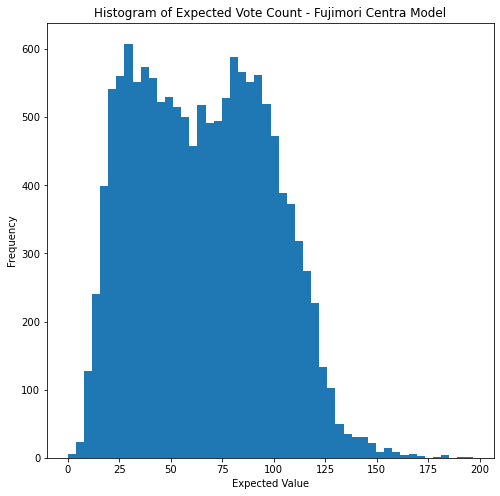

In [119]:
plt.figure(figsize=(8,8))
plt.hist(Fuji2t_fittedvals, bins = 50)
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Vote Count - Fujimori Centra Model')
plt.show()

In [120]:
Fuji2t_fittedvals.sort_values() 

59680     -0.065565
38807      0.041444
22114      0.150738
65139      1.364134
70064      2.556929
            ...    
57254    183.353128
32047    184.342433
25581    184.903539
47851    192.962108
47850    196.957960
Length: 14039, dtype: float64

Only two values are negative and are so close to zero, it won't be necessary to replace them. 

In [121]:
## Creating a column with the original residual values of the Central model
dfr['Fuji2t_resids']=Fuji2t_resids

In [122]:
## Creating a column with the original fitted values of the national model
dfr['Fuji2t_fittedvals']=Fuji2t_fittedvals

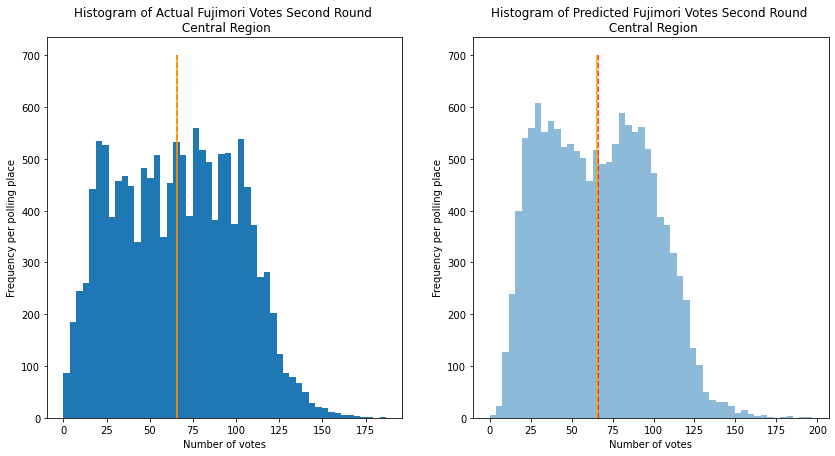

In [123]:
## Plots of predicted vs actual values 
plt.subplots(1,2, figsize=(14,7))

plt.subplot(1,2,1)
plt.hist(dfr[dfr['Region']=='Central']['Fujimori_2'], bins = 50)
plt.vlines(dfr[dfr['Region']=='Central']['Fujimori_2'].mean(), 0, 700, color="red", linestyles="--", label='mean')
plt.vlines(dfr[dfr['Region']=='Central']['Fujimori_2'].median(), 0, 700, color="orange", linestyles="-", label='median')
plt.xlabel('Number of votes')
plt.ylabel('Frequency per polling place')
plt.title('Histogram of Actual Fujimori Votes Second Round \n Central Region')

plt.subplot(1,2,2)
plt.hist(dfr['Fuji2t_fittedvals'], bins = 50, alpha=0.5)
plt.vlines(dfr['Fuji2t_fittedvals'].mean(), 0, 700, color="red", linestyles="--", label='mean')
plt.vlines(dfr['Fuji2t_fittedvals'].median(), 0, 700, color="orange", linestyles="-", label='median')
plt.xlabel('Number of votes')
plt.ylabel('Frequency per polling place')
plt.title('Histogram of Predicted Fujimori Votes Second Round \n Central Region')
plt.show()

The model predicts a bimodal distribution, with similar mean and median as the actual distribution. 

##### 1.2.3.1 Outlier analysis

We will consider the lower bound as the 2.5% tail to left of the residuals distribution. After setting the threshold, we identify which polling places fall into this lower bound.  

**Extreme residuals**

In [124]:
## Calculate the lower bound for the residuals in the Central model
loqt=dfr[dfr['Region']=='Central']['Fuji2t_resids'].quantile(0.025)

In [125]:
## Creating a new outlier calculation dataframe
precentral=dfr[['Geocode', 'State', 'Province', 'District', 'Region','Poll_station', 'Fujimori_2', 'Castillo_2','Fuji2t_fittedvals', 'Fuji2t_resids']]

In [126]:
## just keeping the central observations
outcentral=precentral.loc[precentral['Region']=='Central', :]

In [127]:
outcentral.head(3)

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,Fuji2t_fittedvals,Fuji2t_resids
165,20325,ANCASH,BOLOGNESI,HUALLANCA,Central,1423,58.0,133.0,50.079441,7.920559
166,20501,ANCASH,CASMA,CASMA,Central,1640,93.0,95.0,98.125977,-5.125977
167,20401,ANCASH,CARHUAZ,CARHUAZ,Central,1441,59.0,158.0,55.725422,3.274578


In [128]:
## Create a column to flag extreme values to the left
outcentral['nleft']=0

In [129]:
## Assing a value of 1 to those residuls that are below the 2.5% value of the distibution
outcentral.loc[outcentral['Fuji2t_resids']<loqt, 'nleft']=1

In [130]:
outcentral.nleft.value_counts()

0    13688
1      351
Name: nleft, dtype: int64

A possible 351 outliers are identified. 

**Extreme vote count**

In [131]:
## Calculalting the percentiles for the Fujimori_2 vote distribution
quant=[0.003, 0.025, 0.05, 0.165, 0.5, 0.665, 0.95, 0.975, 0.997]

for i in quant:
    votes=dfr[dfr['Region']=='Central']['Fujimori_2'].quantile(i)
    _th=100*i
    print(f'The {_th} th quantile is {votes} votes')

The 0.3 th quantile is 2.0 votes
The 2.5 th quantile is 9.0 votes
The 5.0 th quantile is 14.0 votes
The 16.5 th quantile is 27.0 votes
The 50.0 th quantile is 66.0 votes
The 66.5 th quantile is 84.0 votes
The 95.0 th quantile is 120.0 votes
The 97.5 th quantile is 129.0 votes
The 99.7 th quantile is 152.0 votes


In this case, 9 votes is the lower bound at the 2.5%

**Intersecting extreme negative residuals and low vote count**

In [132]:
## Create a column for negative outliers 
outcentral['neg_out']=0
outcentral.loc[(outcentral['nleft']==1) & (outcentral['Fujimori_2']<10), 'neg_out']=1

In [133]:
#Let's create a dataframe for Fujimori's extreme negative outliers in the Central region
exnegft=outcentral[outcentral['neg_out']==1]

In [134]:
exnegft.head(3)

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,Fuji2t_fittedvals,Fuji2t_resids,nleft,neg_out
886,60703,CAJAMARCA,HUALGAYOC,HUALGAYOC,Central,12490,5.0,190.0,37.251791,-32.251791,1,1
1013,60304,CAJAMARCA,CELENDIN,HUASMIN,Central,900829,1.0,208.0,29.747746,-28.747746,1,1
1479,80118,HUANCAVELICA,HUANCAVELICA,YAULI,Central,901319,0.0,211.0,34.364346,-34.364346,1,1


In [135]:
exnegft.shape

(60, 12)

These are a possible 60 more outliers. Let's do feature engineering before merging. 

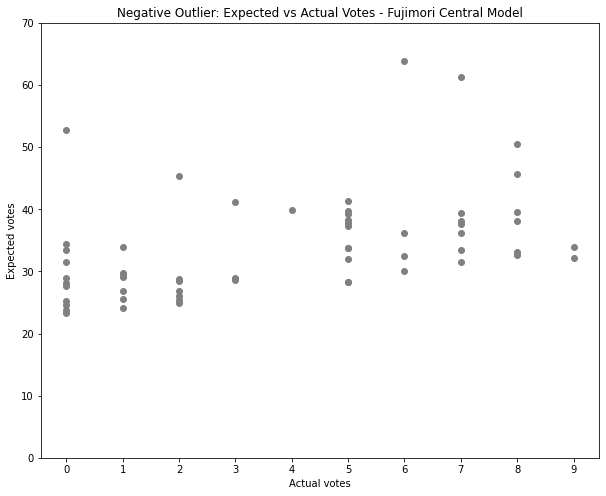

In [136]:
## Scatter plot of expected vs actual votes for 184 "flagged" polling places 
plt.figure(figsize=(10,8))
plt.scatter(exnegft['Fujimori_2'], exnegft['Fuji2t_fittedvals'], color='gray')
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(0, 80, step=10))
plt.title('Negative Outlier: Expected vs Actual Votes - Fujimori Central Model')
plt.show()

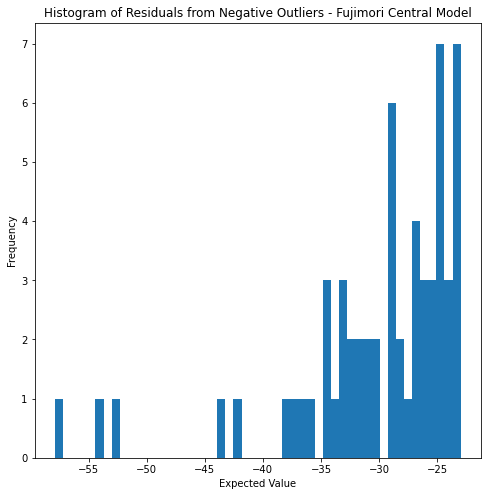

In [137]:
plt.figure(figsize=(8,8))
plt.hist(exnegft['Fuji2t_resids'], bins = 50)
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals from Negative Outliers - Fujimori Central Model')
plt.show()

In [138]:
exnegft['Fuji2t_resids'].describe()

count    60.000000
mean    -30.178337
std       7.518938
min     -57.919546
25%     -32.855130
50%     -28.372959
75%     -24.862103
max     -22.967795
Name: Fuji2t_resids, dtype: float64

Although we see more cases on the extrems of the distribution than in other regions, 75% of the distribution is between -22 and -33. 

#### 1.2.4 East Model

In [139]:
## The target variable is the vote count per polling place for Fujimori in the second round 
yfe=dfr[dfr['Region']=='East'].iloc[:,9]

In [140]:
## The independent variables are the total votes for the second round and the votes of individual candidates in the first round 
Xe=dfr[dfr['Region']=='East'].iloc[:,[17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39]]

In [141]:
## This is the general model at the national level 
Xe=sm.add_constant(Xe)

# 1. Instantiate model
Fuji2e = sm.OLS(yfe,Xe)

# 2. Fit model
Fuji2e_results = Fuji2e.fit()

Fuji2e_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Fujimori_2   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     1478.
Date:                Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:20:14   Log-Likelihood:                -29979.
No. Observations:                7258   AIC:                         6.000e+04
Df Residuals:                    7238   BIC:                         6.014e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.5344      0.776     23.881      0.000      17.013      20.056
Humala         0.2220      0.017     13.187      0.000       0.189       0.255
Arana         -0.5902      0.175     -3.370      0.001      -0.934      -0.247
Guzman        -0.1373      0.105     -1.313      0.189      -0.342       0.068
Santos        -0.0742      0.250     -0.297      0.767      -0.564       0.416
Forsyth        0.4406      0.026     17.159      0.000       0.390       0.491
Lescano        0.1486      0.023      6.359      0.000       0.103       0.194
De_Soto        1.1879      0.028     43.138      0.000       1.134       1.242
Urresti       -0.1591      0.029     -5.563      0.000      -0.215      -0.103
Mendoza        0.0248      0.037      0.664      0.507      -0.048       0.098
Beingolea      0.8927      0.102      8.718      0.000       0.692       1.093
Fujimori_1     1.6190      0.017     93.650      0.000       1.585       1.653
Vega          -0.5168      0.088     -5.892      0.000      -0.689      -0.345
Lopez          0.8105      0.035     23.435      0.000       0.743       0.878
Galvez        -0.1347      0.186     -0.724      0.469      -0.499       0.230
Salaverry      0.1889      0.048      3.925      0.000       0.095       0.283
Castillo_1    -0.2582      0.012    -22.019      0.000      -0.281      -0.235
Alcantara     -0.0416      0.209     -0.200      0.842      -0.450       0.367
Acuna          0.4156      0.023     17.760      0.000       0.370       0.461
Vote_delta     0.3166      0.017     18.477      0.000       0.283       0.350
==============================================================================
Omnibus:                      335.364   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              817.192
Skew:                           0.266   Prob(JB):                    3.54e-178
Kurtosis:                       4.555   Cond. No.                         207.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R2 fot this model is 0.795, the lowest so far. Five candidates are not statistically significant: Guzman(19) Santos(20), Mendoza(25), Galvez(30) and Alcantara(33). We will keep them to maintain consistency with the rest of the models. 

In [142]:
## Storing fitted values and residuals. 
Fuji2e_resids = Fuji2e_results.resid
Fuji2e_fittedvals = Fuji2e_results.fittedvalues

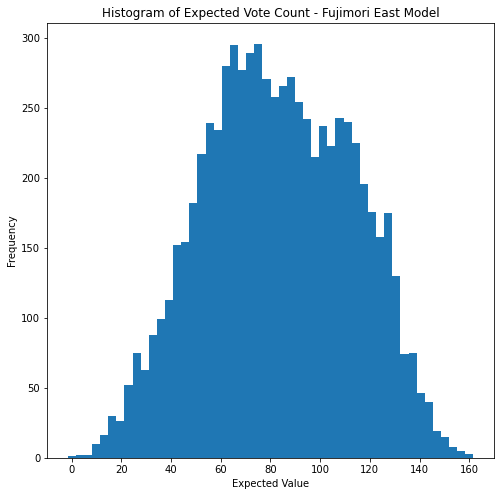

In [143]:
plt.figure(figsize=(8,8))
plt.hist(Fuji2e_fittedvals, bins = 50)
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Vote Count - Fujimori East Model')
plt.show()

In [144]:
Fuji2e_fittedvals.sort_values() 

21339     -1.625454
63506      2.778855
26486      3.686083
37088      6.763838
26441      8.031961
            ...    
10348    156.596104
47365    156.634799
14963    158.654588
36021    158.812665
51986    161.686845
Length: 7258, dtype: float64

Only one negative fitted value of 7258. We'll keep the original fitted values. 

In [145]:
## Creating a column with the original residual values of the Central model
dfr['Fuji2e_resids']=Fuji2e_resids

In [146]:
## Creating a column with the original fitted values of the national model
dfr['Fuji2e_fittedvals']=Fuji2e_fittedvals

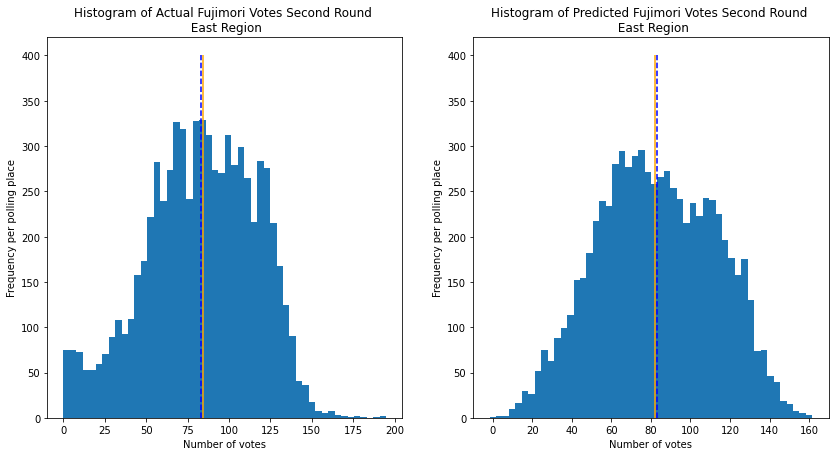

In [147]:
## Plots of predicted vs actual values 
plt.subplots(1,2, figsize=(14,7))

plt.subplot(1,2,1)
plt.hist(dfr[dfr['Region']=='East']['Fujimori_2'], bins = 50)
plt.vlines(dfr[dfr['Region']=='East']['Fujimori_2'].mean(), 0, 400, color="blue", linestyles="--", label='mean')
plt.vlines(dfr[dfr['Region']=='East']['Fujimori_2'].median(), 0, 400, color="orange", linestyles="-", label='median')
plt.xlabel('Number of votes')
plt.ylabel('Frequency per polling place')
plt.title('Histogram of Actual Fujimori Votes Second Round \n East Region')

plt.subplot(1,2,2)
plt.hist(dfr['Fuji2e_fittedvals'], bins = 50)
plt.vlines(dfr['Fuji2e_fittedvals'].mean(), 0, 400, color="blue", linestyles="--", label='mean')
plt.vlines(dfr['Fuji2e_fittedvals'].median(), 0, 400, color="orange", linestyles="-", label='median')
plt.xlabel('Number of votes')
plt.ylabel('Frequency per polling place')
plt.title('Histogram of Predicted Fujimori Votes Second Round \n East Region')
plt.show()

It's important to note that the actual distribtion shows larger frequencies at the left tail than the predicted distribution. As we saw at the national level, Loreto and Amazonas are in this region. 

##### 1.2.4.1 Outlier Analysis

**Extreme residuals**

In [148]:
## Calculate the lower bound for the residuals in the East model
loqe=dfr[dfr['Region']=='East']['Fuji2e_resids'].quantile(0.025)

In [149]:
## Creating a new outlier calculation dataframe
preeast=dfr[['Geocode', 'State', 'Province', 'District', 'Region','Poll_station', 'Fujimori_2', 'Castillo_2','Fuji2e_fittedvals', 'Fuji2e_resids']]

In [150]:
## just keeping the east observations
outeast=preeast.loc[preeast['Region']=='East', :]

In [151]:
outeast.head(3)

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,Fuji2e_fittedvals,Fuji2e_resids
0,10101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,East,13,87.0,115.0,90.060274,-3.060274
1,10101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,East,26,58.0,71.0,72.124403,-14.124403
2,10101,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,East,30,50.0,71.0,62.295895,-12.295895


In [152]:
## Create a column to flag extreme values to the left
outeast['nleft']=0

In [153]:
## Assing a value of 1 to those residuls that are below the 2.5% value of the distibution
outeast.loc[outeast['Fuji2e_resids']<loqe, 'nleft']=1

In [154]:
## How many possible outliers are there?
outeast.nleft.value_counts()

0    7076
1     182
Name: nleft, dtype: int64

182 potential outliers. 

**Extreme vote count**

In [155]:
## Calculalting the percentiles for the Fujimori_2 vote distribution
quant=[0.003, 0.025, 0.05, 0.165, 0.5, 0.665, 0.95, 0.975, 0.997]

for i in quant:
    votes=dfr[dfr['Region']=='East']['Fujimori_2'].quantile(i)
    _th=100*i
    print(f'The {_th} th quantile is {votes} votes')

The 0.3 th quantile is 1.0 votes
The 2.5 th quantile is 9.0 votes
The 5.0 th quantile is 22.0 votes
The 16.5 th quantile is 51.0 votes
The 50.0 th quantile is 84.0 votes
The 66.5 th quantile is 100.0 votes
The 95.0 th quantile is 132.0 votes
The 97.5 th quantile is 138.0 votes
The 99.7 th quantile is 157.0 votes


In this case, 9 votes is the lower bound at the 2.5%

**Intersecting extreme residuals and extreme low vote counts**

In [156]:
## Create a column for negative outliers 
outeast['neg_out']=0
outeast.loc[(outeast['nleft']==1) & (outeast['Fujimori_2']<10), 'neg_out']=1

In [157]:
#Let's create a dataframe for Fujimori's extreme negative outliers in the Central region
exnegfe=outeast[outeast['neg_out']==1]

In [158]:
exnegfe.shape

(44, 12)

There are 44 potential extreme outliers. 

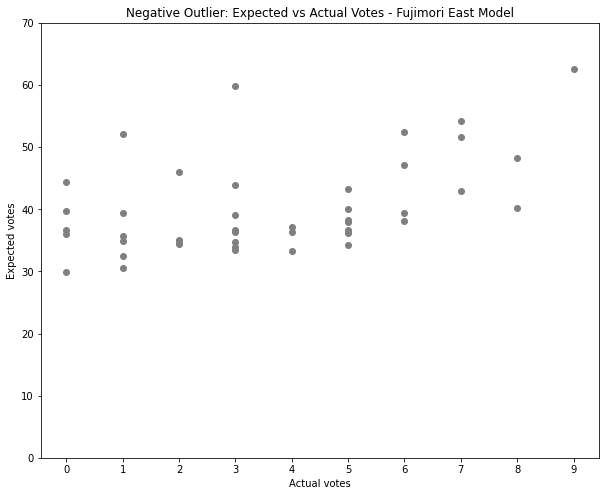

In [159]:
## Scatter plot of expected vs actual votes for "flagged" polling places 
plt.figure(figsize=(10,8))
plt.scatter(exnegfe['Fujimori_2'], exnegfe['Fuji2e_fittedvals'], color='gray')
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
plt.xticks(np.arange(0, 10, step=1))
plt.yticks(np.arange(0, 80, step=10))
plt.title('Negative Outlier: Expected vs Actual Votes - Fujimori East Model')
plt.show()

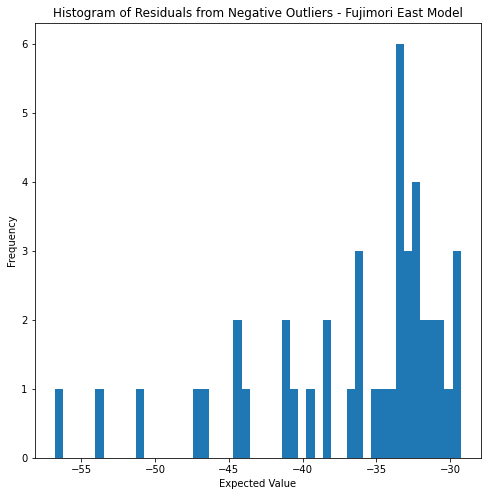

In [160]:
plt.figure(figsize=(8,8))
plt.hist(exnegfe['Fuji2e_resids'], bins = 50)
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals from Negative Outliers - Fujimori East Model')
plt.show()

In [161]:
exnegfe['Fuji2e_resids'].describe()

count    44.000000
mean    -36.571138
std       6.701335
min     -56.790945
25%     -39.833778
50%     -33.567339
75%     -32.186268
max     -29.282944
Name: Fuji2e_resids, dtype: float64

In this case, we see tighter distribution. The mode is slightly below -35, and the range is -29.3 to 56.8. 

#### 1.2.5 Abroad Model

In [162]:
## The target variable is the vote count per polling place for Fujimori in the second round 
yfa=dfr[dfr['Region']=='Abroad'].iloc[:,9]

In [163]:
## The independent variables are the total votes for the second round and the votes of individual candidates in the first round 
Xa=dfr[dfr['Region']=='Abroad'].iloc[:,[17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39]]

In [164]:
## This is the general model at the regional level 
Xa=sm.add_constant(Xa)

# 1. Instantiate model
Fuji2a = sm.OLS(yfa,Xa)

# 2. Fit model
Fuji2a_results = Fuji2a.fit()

Fuji2a_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Fujimori_2   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     343.3
Date:                Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:20:16   Log-Likelihood:                -10282.
No. Observations:                2770   AIC:                         2.060e+04
Df Residuals:                    2750   BIC:                         2.072e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1352      0.725     23.631      0.000      15.713      18.557
Humala         0.2094      0.206      1.019      0.308      -0.194       0.613
Arana          0.7329      0.254      2.886      0.004       0.235       1.231
Guzman         0.2886      0.106      2.721      0.007       0.081       0.496
Santos        -0.0023      0.262     -0.009      0.993      -0.515       0.511
Forsyth        0.4940      0.078      6.323      0.000       0.341       0.647
Lescano        0.3021      0.078      3.860      0.000       0.149       0.456
De_Soto        1.1378      0.050     22.732      0.000       1.040       1.236
Urresti       -0.0095      0.135     -0.071      0.943      -0.274       0.254
Mendoza       -0.3817      0.042     -9.059      0.000      -0.464      -0.299
Beingolea      0.6099      0.134      4.539      0.000       0.346       0.873
Fujimori_1     1.3014      0.040     32.809      0.000       1.224       1.379
Vega          -0.6894      0.287     -2.400      0.016      -1.253      -0.126
Lopez          1.0376      0.037     27.693      0.000       0.964       1.111
Galvez        -0.5207      0.333     -1.566      0.118      -1.173       0.131
Salaverry     -0.0724      0.160     -0.452      0.651      -0.386       0.241
Castillo_1    -0.6408      0.061    -10.475      0.000      -0.761      -0.521
Alcantara      0.3294      0.367      0.898      0.369      -0.390       1.049
Acuna          0.7629      0.141      5.399      0.000       0.486       1.040
Vote_delta     0.5161      0.011     47.030      0.000       0.495       0.538
==============================================================================
Omnibus:                     1453.134   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114128.649
Skew:                           1.615   Prob(JB):                         0.00
Kurtosis:                      34.280   Cond. No.                         145.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is the lowest R2 so far, which makes sense because the Abroad region has the lowest number of observations and lowest turnout in the first and second rounds, and showed very few votes for the minor candidates. Humala (column 17), Santos (20), Urresti (24), Salaverry (30), Galvez (31) and Alcantara (33) are not statictically significant. Other signs are as expected. We keep them for consistency with the other models. 

In [165]:
## Storing fitted values and residuals. 
Fuji2a_resids = Fuji2a_results.resid
Fuji2a_fittedvals = Fuji2a_results.fittedvalues

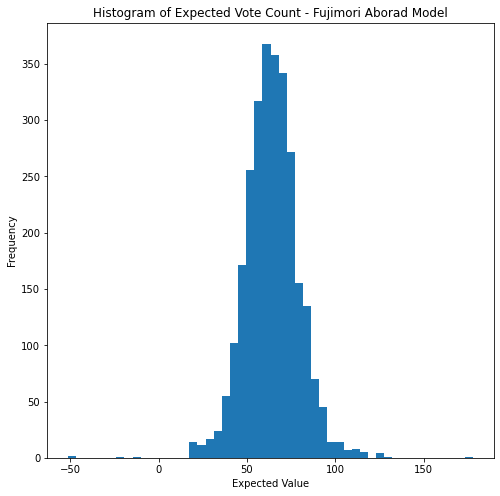

In [166]:
plt.figure(figsize=(8,8))
plt.hist(Fuji2a_fittedvals, bins = 50)
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Vote Count - Fujimori Aborad Model')
plt.show()

There are various predicted negative values that have to be capped at 0 and the residuals need to be recalculated. 

In [167]:
Fuji2a_fittedvals.sort_values()

42531    -51.448773
37181    -48.652006
1408     -20.132469
42393    -12.993412
37794     17.872021
            ...    
21977    123.556296
69327    124.170862
69316    126.099816
32513    129.656462
68807    178.187381
Length: 2770, dtype: float64

In this case, there are 4 fitted values that need to be replaced with zeros. 

In [168]:
## Creating a column with the original residual values of the Abroad model
dfr['Fuji2a_resids']=Fuji2a_resids

In [169]:
## Creating a column with the original fitted values of the Abroad model
dfr['Fuji2a_fittedvals']=Fuji2a_fittedvals

In [170]:
## Creating a copy of this column to modify with the new fitted values. 
dfr['NewFuji2a_fval']=Fuji2a_fittedvals

In [171]:
## Setting these rows with a value of zero
dfr.loc[dfr['NewFuji2a_fval']<0, 'NewFuji2a_fval']=0

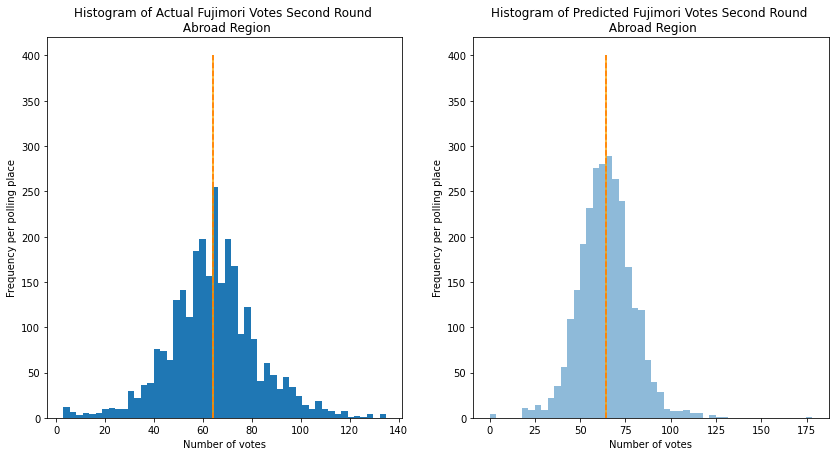

In [172]:
## Plots of predicted vs actual values 
plt.subplots(1,2, figsize=(14,7))

plt.subplot(1,2,1)
plt.hist(dfr[dfr['Region']=='Abroad']['Fujimori_2'], bins = 50)
plt.vlines(dfr[dfr['Region']=='Abroad']['Fujimori_2'].mean(), 0, 400, color="red", linestyles="--", label='mean')
plt.vlines(dfr[dfr['Region']=='Abroad']['Fujimori_2'].median(), 0, 400, color="orange", linestyles="-", label='median')
plt.xlabel('Number of votes')
plt.ylabel('Frequency per polling place')
plt.title('Histogram of Actual Fujimori Votes Second Round \n Abroad Region')

plt.subplot(1,2,2)
plt.hist(dfr['NewFuji2a_fval'], bins = 50, alpha=0.5)
plt.vlines(dfr['NewFuji2a_fval'].mean(), 0, 400, color="red", linestyles="--", label='mean')
plt.vlines(dfr['NewFuji2a_fval'].median(), 0, 400, color="orange", linestyles="-", label='median')
plt.xlabel('Number of votes')
plt.ylabel('Frequency per polling place')
plt.title('Histogram of Predicted Fujimori Votes Second Round \n Abroad Region')
plt.show()

In [173]:
dfr[dfr['Region']=='Abroad']['Fujimori_2'].describe()

count    2770.000000
mean       64.196751
std        18.187020
min         3.000000
25%        54.000000
50%        64.000000
75%        74.000000
max       135.000000
Name: Fujimori_2, dtype: float64

In [174]:
dfr['NewFuji2a_fval'].describe()

count    2770.000000
mean       64.244847
std        14.982375
min         0.000000
25%        54.728014
50%        64.058918
75%        73.082544
max       178.187381
Name: NewFuji2a_fval, dtype: float64

The estimated distribution has a longer tail on the right. The stdev of the original distribution is higher, but some of it has to do with the fact that the left tail was capped at zero. 

In [175]:
## Estimating the capped residuals 
dfr['NewFuji2ares']=dfr[dfr['Region']=='Abroad']['Fujimori_2']-dfr[dfr['Region']=='Abroad']['NewFuji2a_fval']

##### 1.2.5.1 Outlier analysis

**Extreme residuals**

In [176]:
## Calculate the lower bound for the residuals in the South model
loqa=dfr[dfr['Region']=='Abroad']['NewFuji2ares'].quantile(0.025)

In [177]:
## Creating a new outlier calculation dataframe
preabroad=dfr[['Geocode', 'State', 'Province', 'District', 'Region','Poll_station', 'Fujimori_2', 'Castillo_2','NewFuji2a_fval', 'NewFuji2ares']]

In [178]:
## just keeping the abroad observations
outabroad=preabroad.loc[preeast['Region']=='Abroad', :]

In [179]:
outabroad.head(3)

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,NewFuji2a_fval,NewFuji2ares
61,920202,AMERICA,ARGENTINA,BUENOS AIRES,Abroad,79950,53.0,27.0,52.601843,0.398157
73,920202,AMERICA,ARGENTINA,BUENOS AIRES,Abroad,80031,49.0,72.0,51.940252,-2.940252
74,920202,AMERICA,ARGENTINA,BUENOS AIRES,Abroad,79963,37.0,50.0,50.126670,-13.126670


In [180]:
## Create a column to flag extreme values to the left
outabroad['nleft']=0

In [181]:
## Assing a value of 1 to those residuls that are below the 2.5% value of the distibution
outabroad.loc[outabroad['NewFuji2ares']<loqa, 'nleft']=1

In [182]:
outabroad.nleft.value_counts()

0    2700
1      70
Name: nleft, dtype: int64

There are 70 possible outlier observations. 

**Extreme vote count**

In [183]:
## Calculalting the percentiles for the Fujimori_2 vote distribution
quant=[0.003, 0.025, 0.05, 0.165, 0.5, 0.665, 0.95, 0.975, 0.997]

for i in quant:
    votes=dfr[dfr['Region']=='Abroad']['Fujimori_2'].quantile(i)
    _th=100*i
    print(f'The {_th} th quantile is {votes} votes')

The 0.3 th quantile is 5.0 votes
The 2.5 th quantile is 28.22500000000001 votes
The 5.0 th quantile is 36.0 votes
The 16.5 th quantile is 49.0 votes
The 50.0 th quantile is 64.0 votes
The 66.5 th quantile is 70.0 votes
The 95.0 th quantile is 96.0 votes
The 97.5 th quantile is 103.0 votes
The 99.7 th quantile is 124.07900000000063 votes


The lower bound for the 2.5%th percentile is 28 votes. 

**Intersecting extreme negative residuals and extreme vote count**

In [184]:
## Create a column for negative outliers 
outabroad['neg_out']=0
outabroad.loc[(outabroad['nleft']==1) & (outabroad['Fujimori_2']<29), 'neg_out']=1

In [185]:
#Let's create a dataframe for Fujimori's extreme negative outliers in the Abroad region
exnegfa=outabroad[outabroad['neg_out']==1]

In [186]:
exnegfa.shape

(13, 12)

13 possible extreme outliers have been found. 

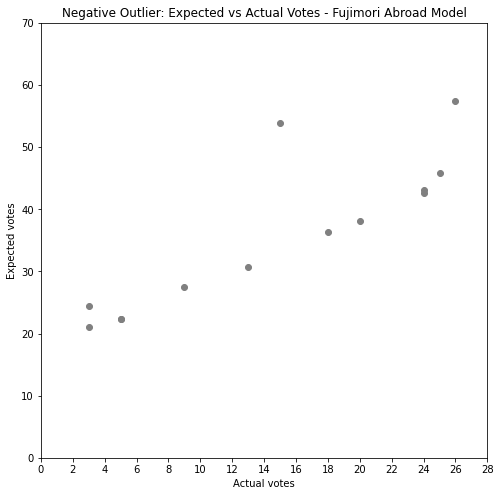

In [187]:
## Scatter plot of expected vs actual votes for "flagged" polling places 
plt.figure(figsize=(8,8))
plt.scatter(exnegfa['Fujimori_2'], exnegfa['NewFuji2a_fval'], color='gray')
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
plt.xticks(np.arange(0, 30, step=2))
plt.yticks(np.arange(0, 80, step=10))
plt.title('Negative Outlier: Expected vs Actual Votes - Fujimori Abroad Model')
plt.show()

The abroad distribution is a bit disperse and does not have enough observations to infer a patter, similar to the case of the South distribution. 

#### 1.2.6. Concatenating the regional models

In this section we will concatenate the five resulting regional dataframes into one to compare with the results of the national model. 

- Coast: exnegfc
- South: exnegfs
- Central: exnegft
- East: exnegfe
- Abroad: exnegfa

First, we need to rename all fitted values and residual columns that are specific to each df. 

In [188]:
## rename the fitted and residual columns for Coast 
exnegfc.rename(columns={'NewFuji2c_fval':'fitted', 'NewFuji2cres':'residuals'}, inplace=True)

In [189]:
## rename the fitted and residual columns for South
exnegfs.rename(columns={'NewFuji2s_fval':'fitted', 'NewFuji2sres':'residuals'}, inplace=True)

In [190]:
## rename the fitted and residual columns for Central 
exnegft.rename(columns={'Fuji2t_fittedvals':'fitted', 'Fuji2t_resids':'residuals'}, inplace=True)

In [191]:
## rename the fitted and residual columns for East 
exnegfe.rename(columns={'Fuji2e_fittedvals':'fitted', 'Fuji2e_resids':'residuals'}, inplace=True)

In [192]:
## rename the fitted and residual columns for Abroad
exnegfa.rename(columns={'NewFuji2a_fval':'fitted', 'NewFuji2ares':'residuals'}, inplace=True)

*Next, start concatenating*

In [193]:
## Concatenating Coast and South
totnegout=pd.concat([exnegfc, exnegfs], ignore_index=True)

In [194]:
totnegout.shape

(95, 12)

In [195]:
totnegout.head(3)

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,fitted,residuals,nleft,neg_out
0,190201,PIURA,AYABACA,AYABACA,Coast,66622,15.0,92.0,52.957746,-37.957746,1,1
1,190205,PIURA,AYABACA,PACAIPAMPA,Coast,66803,19.0,94.0,51.882637,-32.882637,1,1
2,190206,PIURA,AYABACA,SAPILLICA,Coast,66843,17.0,148.0,63.184769,-46.184769,1,1


The new df has the 71 outliers from the Coast and 24 outliers from the South.  

In [196]:
## Concatenating with Central
totnegout=pd.concat([totnegout, exnegft], ignore_index=True)

In [197]:
totnegout.shape

(155, 12)

We've added the 60 outliers from the central regions. 

In [198]:
## Concatenating with East
totnegout=pd.concat([totnegout, exnegfe], ignore_index=True)

In [199]:
totnegout.shape

(199, 12)

In [200]:
totnegout.head(3)

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,fitted,residuals,nleft,neg_out
0,190201,PIURA,AYABACA,AYABACA,Coast,66622,15.0,92.0,52.957746,-37.957746,1,1
1,190205,PIURA,AYABACA,PACAIPAMPA,Coast,66803,19.0,94.0,51.882637,-32.882637,1,1
2,190206,PIURA,AYABACA,SAPILLICA,Coast,66843,17.0,148.0,63.184769,-46.184769,1,1


We've added the 44 outliers from the central regions. 

In [201]:
## Concatenating with Abroad
totnegout=pd.concat([totnegout, exnegfa], ignore_index=True)

In [202]:
totnegout.shape

(212, 12)

We've added the 13 outliers from the central regions. 

In [203]:
## drop the nleft and neg_out columns. they are not necessary anymore
totnegout.drop(columns=['nleft', 'neg_out'], inplace=True)

In [204]:
totnegout.head(3)

,Geocode,State,Province,District,Region,Poll_station,Fujimori_2,Castillo_2,fitted,residuals
0,190201,PIURA,AYABACA,AYABACA,Coast,66622,15.0,92.0,52.957746,-37.957746
1,190205,PIURA,AYABACA,PACAIPAMPA,Coast,66803,19.0,94.0,51.882637,-32.882637
2,190206,PIURA,AYABACA,SAPILLICA,Coast,66843,17.0,148.0,63.184769,-46.184769


In [205]:
## We'll export this clean dataset for use in Tableau
totnegout.to_csv('data/fuji_totnegoutregion.csv', index=False)

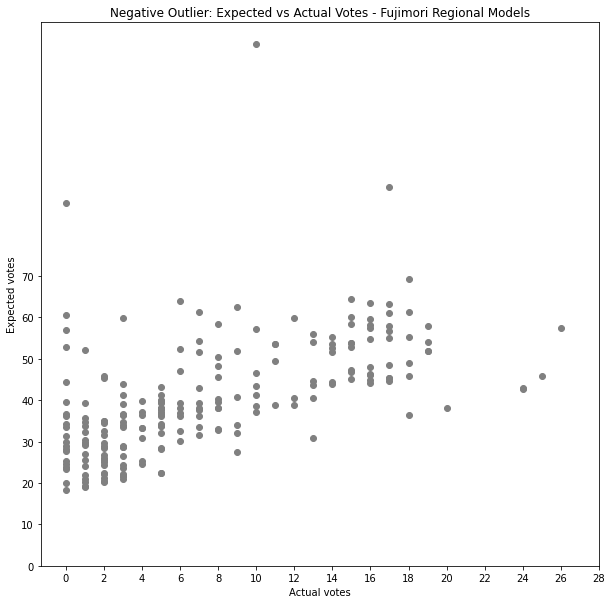

In [206]:
## Scatter plot of expected vs actual votes for flagged" polling places 
plt.figure(figsize=(10,10))
plt.scatter(totnegout['Fujimori_2'], totnegout['fitted'], color='gray')
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
plt.xticks(np.arange(0, 30, step=2))
plt.yticks(np.arange(0, 80, step=10))
plt.title('Negative Outlier: Expected vs Actual Votes - Fujimori Regional Models')
plt.show()

We see a similar picture than the national model. Outliers become more disperse above 40 expected votes.  

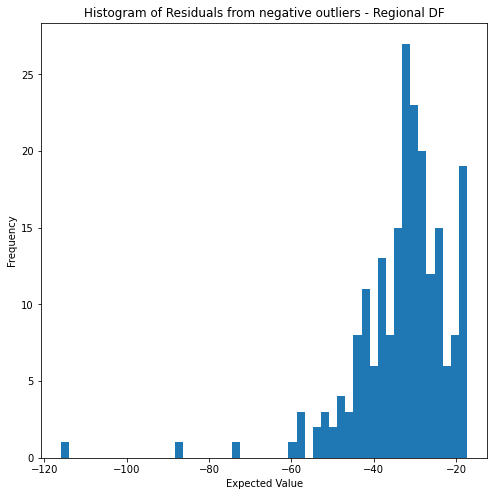

In [207]:
plt.figure(figsize=(8,8))
plt.hist(totnegout['residuals'], bins = 50)
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals from negative outliers - Regional DF')
plt.show()

In [208]:
totnegout.residuals.describe()

count    212.000000
mean     -32.996571
std       11.711305
min     -115.929494
25%      -38.254996
50%      -31.404845
75%      -26.270543
max      -17.305989
Name: residuals, dtype: float64

The histogram of residuals in the Negative Outliers set shows some extreme oultiers to the left, yet most of the distribution is concentrated between -20 and -40. Is a value of 17 less votes than expected enough to call attention to a potential problem? Probably not 

We will use Benford's law to complement this analysis in the following notebook.  

In [209]:
totnegout['State'].value_counts()

PIURA           54
CAJAMARCA       35
LORETO          23
AMAZONAS        19
PUNO            14
HUANCAVELICA    10
AYACUCHO         8
LIMA             8
HUANUCO          7
ANCASH           7
EUROPA           6
AMERICA          5
LA LIBERTAD      5
LAMBAYEQUE       3
UCAYALI          2
CUSCO            2
JUNIN            1
TUMBES           1
ASIA             1
AFRICA           1
Name: State, dtype: int64

We do see some reagional concentration in these outliers. Piura, Cajamarca and Amazonas are home turf for Castillo, so this could just be momentum from a local candidate. We will delve more into this aspect in the Tableau analysis. 

In [210]:
## Calculating the number of votes for Castillo and Fujimori in this subset 
totnegout['Castillo_2'].sum()-totnegout['Fujimori_2'].sum()

25955.0

In this case, the net change in votes would be 25955, not enough to overturn the 44k difference. 

**Conclusions**:

- The total nef Fujimori gain from removing the negative outlier votes is using two different methodologies is between 24k and 26k votes. Even if all the votes in these polling places where annulled, it's not  enough to overturn the results of the election.

- According to this methodology, The negative outlier polls range between 184 and 212 of 84800 of the total dataset: ~ 0.35% of the total. This does not seem indicative of a concerted effort to create negative outliers against one candidate. 

- Negative outlier polls appear in more than 20 regions but are concentrated in a few regions. In both models, the top 5 regions account for more than 70% of all outliers. This could be indicative of Castillo's momentum in certain regions like Amazonas and Cajamarca, his home turf. 

- Visualizations are shown in accompanying Tableau file.


## 2. Castillo Analysis

To complement the analysis, we will analyze a similar Castillo model at the national to present the extreme negative cases from his vote count distribution. Are we seeing similar results?  

### 2.1 National Model

In [211]:
## The target variable is the vote count per polling place for Fujimori in the second round 
ycn=dfr.iloc[:,8]

In [212]:
## The independent variables are the total votes for the second round and the votes of individual candidates in the first round 
Xcn=dfr.iloc[:,[17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39]]

In [213]:
Xcn= sm.add_constant(Xcn)

In [214]:
## This is the general model at the national level 
# 1. Instantiate model
Cast2n = sm.OLS(ycn,Xcn)

# 2. Fit model
Cast2n_results = Cast2n.fit()

Cast2n_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Castillo_2   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                 4.106e+04
Date:                Sun, 18 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:20:18   Log-Likelihood:            -3.4631e+05
No. Observations:               84452   AIC:                         6.927e+05
Df Residuals:                   84432   BIC:                         6.929e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.7488      0.257     84.771      0.000      21.246      22.252
Humala         1.0347      0.011     96.938      0.000       1.014       1.056
Arana          1.7169      0.044     38.918      0.000       1.630       1.803
Guzman        -0.0324      0.019     -1.719      0.086      -0.069       0.005
Santos         0.4074      0.055      7.402      0.000       0.300       0.515
Forsyth        0.1675      0.010     16.129      0.000       0.147       0.188
Lescano        0.8573      0.005    187.897      0.000       0.848       0.866
De_Soto       -0.2581      0.005    -51.391      0.000      -0.268      -0.248
Urresti        0.7656      0.008     91.706      0.000       0.749       0.782
Mendoza        1.1350      0.007    171.127      0.000       1.122       1.148
Beingolea     -0.6705      0.019    -35.897      0.000      -0.707      -0.634
Fujimori_1    -0.1267      0.004    -31.098      0.000      -0.135      -0.119
Vega           1.4019      0.032     43.466      0.000       1.339       1.465
Lopez         -0.1061      0.006    -16.972      0.000      -0.118      -0.094
Galvez         1.6571      0.035     47.309      0.000       1.588       1.726
Salaverry      1.0169      0.018     55.020      0.000       0.981       1.053
Castillo_1     1.1940      0.002    498.693      0.000       1.189       1.199
Alcantara      1.0933      0.044     24.871      0.000       1.007       1.179
Acuna          0.4283      0.006     76.263      0.000       0.417       0.439
Vote_delta     0.1909      0.005     41.868      0.000       0.182       0.200
==============================================================================
Omnibus:                     4977.248   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17754.667
Skew:                           0.214   Prob(JB):                         0.00
Kurtosis:                       5.205   Cond. No.                         302.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R2 is high at the national level, at 90.2. Some of the coefficients of people that endorsed Castillo for the second round are higher than 1 (Mendoza, Arana, Alcantara, Salaverry). This means there endorsements had a multiplicative effect (for everyone of their votes, Castillo got more than one vote in the second round). This points to a momentum in his candidacy. Only Guzman's coefficient is not statistically significant, yet for the sake of consistency I will leave it.  

In [215]:
## Generating the residuals and fitted values
Cast2n_resids = Cast2n_results.resid
Cast2n_fittedvals = Cast2n_results.fittedvalues 

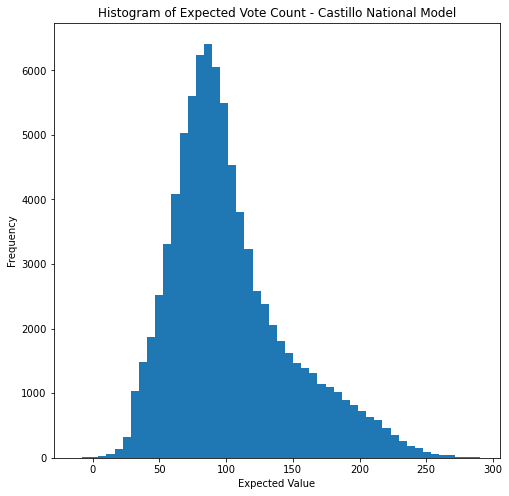

In [216]:
plt.figure(figsize=(8,8))
plt.hist(Cast2n_fittedvals, bins = 50)
plt.xlabel('Expected Value')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Vote Count - Castillo National Model')
plt.show()

Thera aer some predicted values that are zeros and have to be cleaned to zero. 

In [217]:
## Creating a column with the original residual values of the national model
dfr['Cast2n_resids']=Cast2n_resids

In [218]:
## Creating a column with the original fitted values of the national model
dfr['Cast2n_fittedvals']=Cast2n_fittedvals

In [219]:
dfr['Cast2n_fittedvals']

0        119.292452
1         63.650988
2         66.462036
3         63.825967
4        127.483642
            ...    
84447     66.702390
84448     69.102380
84449     95.025225
84450     89.778496
84451    109.756574
Name: Cast2n_fittedvals, Length: 84452, dtype: float64

In [220]:
## Creating a copy of this column to modify with the new fitted values. 
dfr['NewCast2n_fval']=Cast2n_fittedvals

In [221]:
## Locating where the fitted values are less than zero
dfr.loc[dfr['NewCast2n_fval']<0, 'NewCast2n_fval']

8652     -2.091298
13475    -0.507862
35135    -4.081907
37181   -14.035951
42531   -11.430894
45578    -4.379813
46100    -3.941176
56172    -1.613958
56206    -2.781812
71368    -3.973846
Name: NewCast2n_fval, dtype: float64

In the case of Catillo, it's only 9 cases, compared to Fujimori's 591. 

In [222]:
## Setting these 9 rows with a value of zero
dfr.loc[dfr['NewCast2n_fval']<0, 'NewCast2n_fval']=0

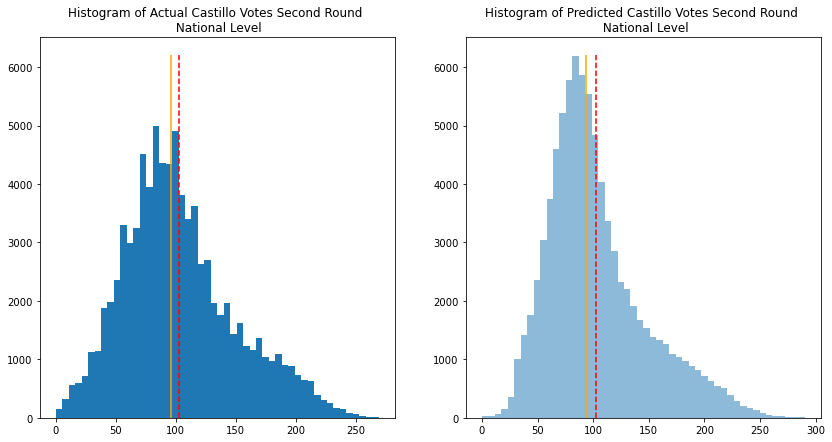

In [223]:
## Plots of predicted vs actual values 
plt.subplots(1,2, figsize=(14,7))

plt.subplot(1,2,1)
plt.hist(dfr['Castillo_2'], bins = 50)
plt.vlines(dfr['Castillo_2'].mean(), 0, 6200, color="red", linestyles="--", label='mean')
plt.vlines(dfr['Castillo_2'].median(), 0, 6200, color="orange", linestyles="-", label='median')
plt.title('Histogram of Actual Castillo Votes Second Round \n National Level')

plt.subplot(1,2,2)
plt.hist(dfr['NewCast2n_fval'], bins = 50, alpha=0.5)
plt.vlines(dfr['NewCast2n_fval'].mean(), 0, 6200, color="red", linestyles="--", label='mean')
plt.vlines(dfr['NewCast2n_fval'].median(), 0, 6200, color="orange", linestyles="-", label='median')
plt.title('Histogram of Predicted Castillo Votes Second Round \n National Level')
plt.show()

In [224]:
dfr['Castillo_2'].describe()

count    84452.000000
mean       102.930446
std         46.753189
min          0.000000
25%         71.000000
50%         96.000000
75%        129.000000
max        269.000000
Name: Castillo_2, dtype: float64

In [225]:
dfr['NewCast2n_fval'].describe()

count    84452.000000
mean       102.931024
std         44.410034
min          0.000000
25%         72.529038
50%         93.464162
75%        124.635678
max        290.140316
Name: NewCast2n_fval, dtype: float64

The distributions are very similar. The predicted distribution has a longer tail on the right.The left tail of the predicted distribution has been capped at zero.

In [226]:
## Estimating the capped residuals 
dfr['NewCast2nres']=dfr['Castillo_2']-dfr['NewCast2n_fval']

### 2.1.1 Checking the normality of residuals

We'll use three tests: 
- Histogram 
- Q-Q plot 
- Shapiro Test

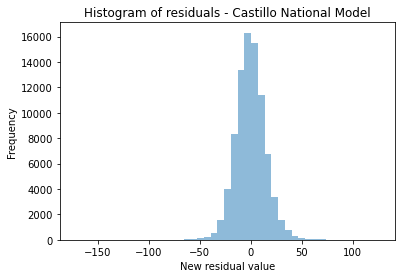

In [227]:
## Using the Histrogram to check the normality of 'capped' residuals
plt.figure()
plt.hist(dfr['NewCast2nres'], bins = 45, alpha=0.5)
plt.xlabel('New residual value')
plt.ylabel('Frequency')
plt.title('Histogram of residuals - Castillo National Model')
plt.show()

In [228]:
## Let's check the statistics of the distribution
dfr['NewCast2nres'].describe()

count    84452.000000
mean        -0.000578
std         14.610658
min       -171.934176
25%         -9.367913
50%         -0.400780
75%          8.827385
max        126.453623
Name: NewCast2nres, dtype: float64

In [229]:
##What is the 95th percentile of the residual distribution? 
dfr['NewCast2nres'].quantile(0.95)

23.9146363476346

In [230]:
## What would be the value of the 95th percentile for the residual distribution if it where normal?
dfr['NewCast2nres'].mean()+2*(dfr['NewCast2nres'].std())

29.220737682323534

The estimated residuals is a little tighter than expected if where normal. 

In [231]:
##What is the 99.7th percentile of the residual distribution?
dfr['NewCast2nres'].quantile(0.997)

50.540926857670804

In [232]:
## What would be the value of the 99.7th percentile for the residual distribution if it where normal?
dfr['NewCast2nres'].mean()+3*(dfr['NewCast2nres'].std())

43.83139567303676

The distribution has a very long left tail, since we see outliers at both ends above 100. This probably means that there are some extreme outliers. 

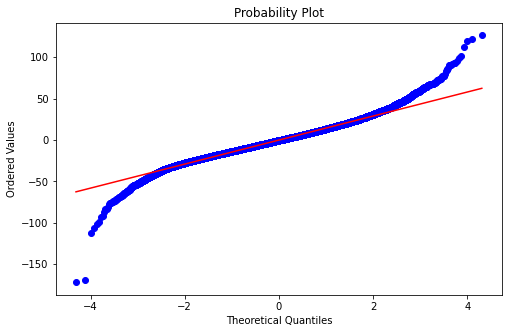

In [233]:
# Using the Q-Q plot of the ´capped' residuals
plt.figure(figsize=(8,5))
prob_plot = stats.probplot(dfr['NewCast2nres'], dist="norm", plot=plt)
plt.title("Probability Plot")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Values")
plt.show()

As expected, the Q-Q plot shows some extreme outliers at both ends. 

In [234]:
##Trying the Shapiro Test:
stats.shapiro(dfr['NewCast2nres'])

ShapiroResult(statistic=0.985511839389801, pvalue=0.0)

The Shapiro Test rejects the null hypothesis that the residuals are normally distributed. 

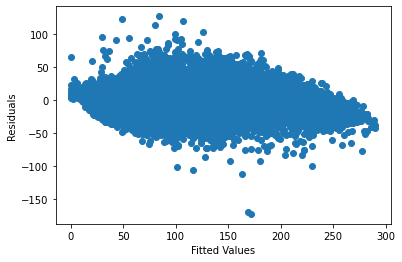

In [235]:
## Homoschedasticity test
plt.figure()
plt.scatter(dfr['NewCast2n_fval'], dfr['NewCast2nres'])
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Residuals are not homoschedastic. Prediction seems to improve as fitted values increase.  

### 2.1.1 Outlier Analysis

##### 2.1.1.1 Extreme residuals

In [236]:
## Calculating the lower bounds 
loqnc=dfr['NewCast2nres'].quantile(0.025)

In [237]:
loqnc

-26.982394334473987

Like in the case of Fujimori, a vote difference of -27 between actual and expected by the model is in the 2.5% percentile. This will be the starting point for analyzing the outliers.  

In [238]:
## Creating a new outlier calculation dataframe
outlierc=dfr[['Geocode', 'State', 'Province', 'District', 'Region','Poll_station', 'Fujimori_2', 'Castillo_2','NewCast2n_fval', 'NewCast2nres']]

In [239]:
## Creating a column to locate those polling places that are outliers on the left of the distribution 
outlierc['nleft']=0

In [240]:
## Flagging all observations with a residual with a negative difference larger than the 2.5% percentile 
outlierc.loc[outlierc['NewCast2nres']<loqnc, 'nleft']=1

In [241]:
outlierc.nleft.value_counts()

0    82340
1     2112
Name: nleft, dtype: int64

##### 2.1.1.2 Extreme vote count

In [242]:
## Calculalting the percentiles for the Castillo_2 vote distribution
quant=[0.003, 0.025, 0.05, 0.165, 0.5, 0.665, 0.95, 0.975, 0.997]

for i in quant:
    votes=dfr['Castillo_2'].quantile(i)
    _th=100*i
    print(f'The {_th} th quantile is {votes} votes')

The 0.3 th quantile is 7.0 votes
The 2.5 th quantile is 25.0 votes
The 5.0 th quantile is 36.0 votes
The 16.5 th quantile is 59.0 votes
The 50.0 th quantile is 96.0 votes
The 66.5 th quantile is 115.0 votes
The 95.0 th quantile is 194.0 votes
The 97.5 th quantile is 209.0 votes
The 99.7 th quantile is 240.0 votes


Castillo's 2.5th percentile is 25 votes, compared to Fujimori's 5 votes. 

##### 2.1.1.3. Intersecting outlier negative residuals and low vote count

In [243]:
## Create a column for negative outliers 
outlierc['neg_out']=0
outlierc.loc[(outlierc['nleft']==1) & (outlierc['Castillo_2']<26), 'neg_out']=1

In [244]:
#Let's create a dataframe for Castillo's extreme negative outliers at the national level
exnegnc=outlierc[outlierc['neg_out']==1]

In [245]:
exnegnc.shape

(265, 12)

There are 265 possible outliers, compared to Fujimori's 184.

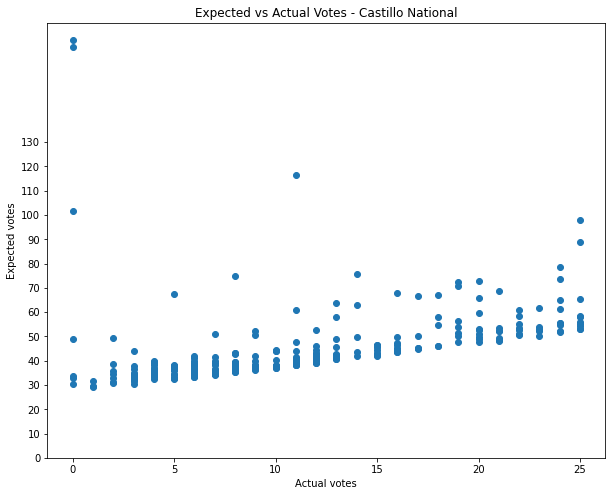

In [246]:
## Scatter plot of expected vs actual votes for 269 "flagged" polling places 
plt.figure(figsize=(10,8))
plt.scatter(exnegnc['Castillo_2'], exnegnc['NewCast2n_fval'])
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
plt.yticks(np.arange(0, 140, step=10))
plt.title('Expected vs Actual Votes - Castillo National')
plt.show()

In [247]:
exnegnc.State.value_counts()

AMERICA        143
LIMA            44
LORETO          19
ASIA            18
PIURA            8
EUROPA           7
CALLAO           7
JUNIN            7
UCAYALI          3
LA LIBERTAD      3
LAMBAYEQUE       2
TUMBES           1
AYACUCHO         1
AREQUIPA         1
PUNO             1
Name: State, dtype: int64

In the case of Castillo, these outliers are coming mostly from Lima and Abroad (America and Asia) and some from Loreto. There was a substantial increase in turnout in the Americas between first and second round.  

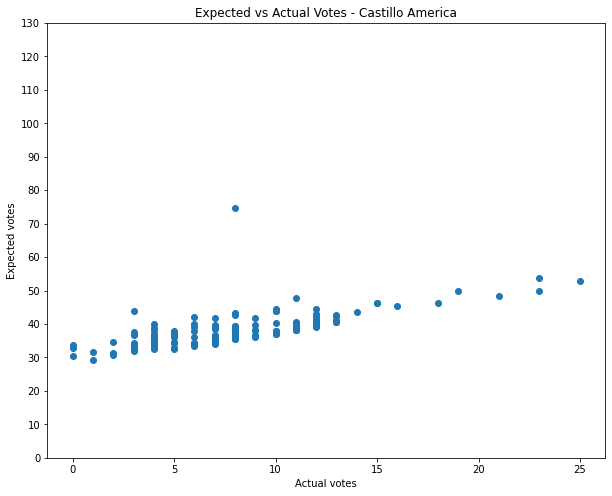

In [248]:
## Scatter plot of expected vs actual votes for flagged" polling places in the American Continent 
plt.figure(figsize=(10,8))
plt.scatter(exnegnc[exnegnc['State']=='AMERICA']['Castillo_2'], exnegnc[exnegnc['State']=='AMERICA']['NewCast2n_fval'])
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
plt.yticks(np.arange(0, 140, step=10))
plt.title('Expected vs Actual Votes - Castillo America')
plt.show()

WE see a similar picture, except for a very few outliers starting at 40. 

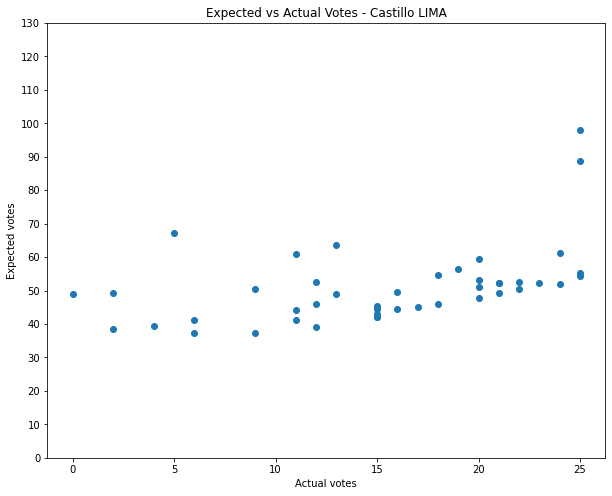

In [249]:
## Scatter plot of expected vs actual votes for flagged" polling places in Lima
plt.figure(figsize=(10,8))
plt.scatter(exnegnc[exnegnc['State']=='LIMA']['Castillo_2'], exnegnc[exnegnc['State']=='LIMA']['NewCast2n_fval'])
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
plt.yticks(np.arange(0, 140, step=10))
plt.title('Expected vs Actual Votes - Castillo LIMA')
plt.show()

Lima's picture is less clear. There is no clear upward trend as in the previous cases. It seems to be more random.

In [252]:
## how much would a net loss for Fujimori would it be if votes where annulled? 
exnegnc['Castillo_2'].sum()-exnegnc['Fujimori_2'].sum()

-25323.0

## 3. Conclusion

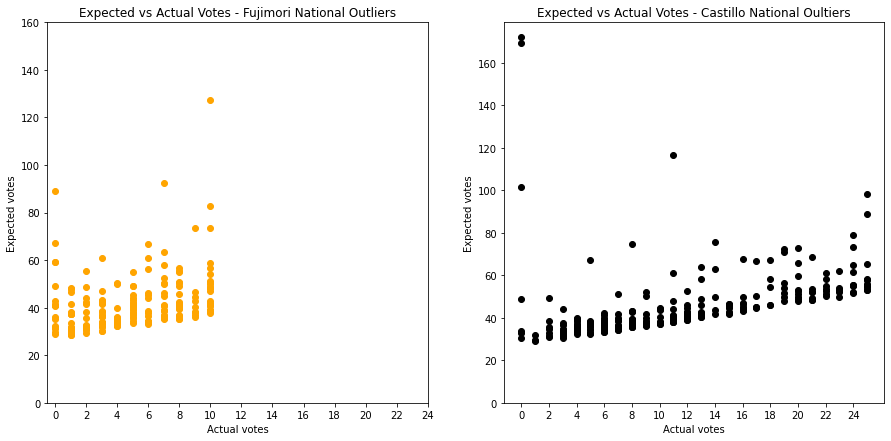

In [258]:
## Putting the results of the national model side by side
plt.subplots(1,2, figsize=(15,7))

plt.subplot(1, 2, 1)
plt.scatter(exnegf['Fujimori_2'], exnegf['fitted'], color='orange')
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
plt.yticks(np.arange(0, 180, step=20))
plt.xticks(np.arange(0, 26, step=2))
plt.title('Expected vs Actual Votes - Fujimori National Outliers')

plt.subplot(1, 2, 2)
plt.scatter(exnegnc['Castillo_2'], exnegnc['NewCast2n_fval'], color='black')
plt.xlabel('Actual votes')
plt.ylabel('Expected votes')
plt.yticks(np.arange(0, 180, step=20))
plt.xticks(np.arange(0, 26, step=2))
plt.title('Expected vs Actual Votes - Castillo National Oultiers')

plt.show()

This a preliminary analysis as an attempt to explain how unusual the behavior of certain poll stations were for both candidates.  The methodology has arbitrarily set a the threshold for outliers at 2.5% of the distribution both for residuals and vote count. The hypothesis behind this thinking is twofold: 

Foul play can happen when votes are counted by hand. Since ballots are discarded, the ballot summary sheet is the only official document. Hence, who ever fills it out, supervised or not, has the final say on what the vote tally actually is. 

If an very low votecount happens for a certain candidate, there is a posibility that it could be the result of changes in the results are the ballot summary sheet level. Some context of the likelihood of this occurence is given by the geographical proximity of these particular polling stations. However, this is not enough to prove its occurence. 

Even with the self-imposed arbitrarity of this method, if all the negative outlier polling stations are eliminated from the final tally, the results do not change. Eliminating the negative outliers selected using a national model and a regional model for Fujimori does not grant her enough votes to pass Castillo. This is without considering Castillo's potential negative outliers, which are in turn more than Fujimori's. 

There is some geographical concentration of the outliers for both candidates. However the magnitude is trivial The accompanying Tableau file can give more light to this phenomenon. Furthermore, concentrations like these could just be the result of candidate momentum. 

If ONPE wanted to promote transparency, expendiency and trust, they could start applying statistical methods such as the one proposed here. The analysis of one election is only the baseline. Yet, subsequent elections would give more context, for example on the likelihood of expecting 20 votes for a candidate and getting 0. They would also give context about how many times an occurence like this occurrence is likely to happend in an election cycle. 

A statistical method like this should only be the first check. An additional layer of monitoring, such as signature analysis (of the ballot summary sheets on this subset could be a second check.   

For now, we will try another statistical method like Benford´s law to have an additional view of the results of regression analysis. 

In [250]:
## We'll export this clean dataset for use in Tableau
exnegnc.to_csv('data/cast_totnegoutnat.csv', index=False)

---